# Trabajo Práctico 2 : Críticas cinematográficas

# Grupo: GPWin - N° 16

Integrantes:

- DIEM, Walter Gabriel

- MAIOLO, Alejandro

## Exploración de datos

Preparación de librerías

In [1]:
%pip install joblib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import re
import optuna

from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
import xgboost
from xgboost import XGBClassifier

from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import make_scorer, f1_score, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

c:\Users\Gabriel\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Seteo de semillas para mejor reproducción de resultados

In [3]:
np.random.seed(1)
tf.random.set_seed(1)

In [4]:
xgboost.config_context(verbosity=2)

### Prepocesamiento de datos

Exploramos el dataset de train y test

In [5]:
critics = pd.read_csv("./datasets/train.csv")
critics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           50000 non-null  int64 
 1   review_es    50000 non-null  object
 2   sentimiento  50000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [6]:
criticsTest = pd.read_csv("./datasets/test.csv")
criticsTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599 entries, 0 to 8598
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         8599 non-null   int64 
 1   review_es  8599 non-null   object
dtypes: int64(1), object(1)
memory usage: 134.5+ KB


Tenemos 50k críticas para train y 8.6k entradas para test en Kaggle. Imprimimos una muestra para ver cómo son.

In [7]:
for critic in critics.sample(20)["review_es"]:
    print("###---###")
    print(critic)

###---###
Sin héroes muertos, se obtienen líneas estúpidas como esa, ya que se debe ver esta película de acción lamentablemente abismal. William Sanders es salvada por su amigo Harry Cotter durante una extracción en Vietnam, pero el enemigo capturado por el enemigo. Avance rápido de diez años y Harry ahora es un operario ruso en lavado de cerebro con un microchip de control mental implantado en su cerebro. Su nuevo Superior Ruso es Ivan jugó a la empuñadura obscena por Nick Nicholson, quien podría agregar no solo no intenta hablar con un acento ruso, sino que se parece a más un asistente de gasolina en Kentucky con sus dientes manchados. Lo que es aún más absurdo es el hecho de que también fue el entrenador de diálogo para esta película. Pronto William es re-reclutado por la CIA para cazar a Harry. Se adapta a Barbara, un luchador por la libertad que ha infiltrado el campamento de El Salvador de Ivan y pronto los dos están soplando la mitad de América del Sur. Algunas escenas son tan h

Cambiamos el nombre de la columna `review_es` a sólo `review`

In [8]:
critics.rename(columns={"review_es": "review"}, inplace=True)
critics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           50000 non-null  int64 
 1   review       50000 non-null  object
 2   sentimiento  50000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


Revisamos valores nulos

In [9]:
criticsNull = critics.isnull().any()
criticsNull

ID             False
review         False
sentimiento    False
dtype: bool

No hay valores nulos en el dataset. Revisamos el balance entre reviews negativas y positivas 

In [10]:
critics["sentimiento"].value_counts()

positivo    25000
negativo    25000
Name: sentimiento, dtype: int64

Hay la misma cantidad de reviews positivas y negativas

Hacemos una función que a cada review le pasará a minúscula las palabras que no estén completamente escritas es mayúsculas

In [11]:
def toLowercaseIfNotFullyUppercase(review):
    words = review.split()
    parsedReview = []

    for word in words:
        if word.isupper():
            parsedReview.append(word)
        else:
            parsedReview.append(word.lower())

    return ' '.join(parsedReview)

In [12]:
critics["review"].apply(toLowercaseIfNotFullyUppercase)

0        uno de los otros críticos ha mencionado que de...
1        una pequeña pequeña producción.la técnica de f...
2        pensé que esta era una manera maravillosa de p...
3        básicamente, hay una familia donde un niño peq...
4        el "amor en el tiempo" de petter mattei es una...
                               ...                        
49995    pensé que esta película hizo un buen trabajo a...
49996    mala parcela, mal diálogo, mala actuación, dir...
49997    soy católica enseñada en escuelas primarias pa...
49998    voy a tener que estar en desacuerdo con el com...
49999    nadie espera que las películas de star trek se...
Name: review, Length: 50000, dtype: object

Encodeamos con LabelEncoder a los sentimientos

In [13]:
labelEncoder = LabelEncoder()
labelEncoder.fit(critics["sentimiento"])

print("Encoding queda:")
print(f"0 = {labelEncoder.inverse_transform([0])[0]}\n1 = {labelEncoder.inverse_transform([1])[0]}")

Encoding queda:
0 = negativo
1 = positivo


In [14]:
critics["sentimiento"] = labelEncoder.transform(critics["sentimiento"])
critics["sentimiento"].sample(4)

45997    0
9976     1
48042    0
3714     0
Name: sentimiento, dtype: int32

Creamos una función que remueva caracteres que no sean una palabra con espacios y los cambiamos por un espacio

In [15]:
def removePunctuation(review):
    return re.sub(r'[^\w\s]', ' ', review)

In [16]:
critics["review"] = critics["review"].apply(removePunctuation)
critics["review"].sample(10)

20895    El único bien  ya sea de los problemas  las pe...
35913    Si bien esto está horriblemente anticuado  deb...
29522    Mark Frechette Estrella como Mark  una univers...
8761     Si es cierto que el sadomasoquismo es una mone...
49943     SIR  ha jugado a LEAR más de 200 veces  pero ...
851      Steven Seagal s films of late have not exactly...
31578     Paso  Hanna Barbera de los años 60 y 70   Qué...
33833    Desde los primeros 10 segundos de tono de negr...
22722    Esta es la peor película absoluta que he visto...
23456    Después de haber visto al cazador de ciervos  ...
Name: review, dtype: object

### Split

Hacemos el split de train y test con relación de ~1/6

In [17]:
critics_x = critics["review"].copy()
critics_y = critics["sentimiento"].copy()

x_train, x_test, y_train, y_test = train_test_split(critics_x,
                                                    critics_y,
                                                    test_size=0.18,
                                                    random_state=0)

### Procesamos conjunto de test de Kaggle

Con el dataset que submitearemos a Kaggle, lo importamos y la hacemos los mismos cambios que se le hicieron al conjunto de training

In [18]:
criticsTest = pd.read_csv("./datasets/test.csv")
criticsTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599 entries, 0 to 8598
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         8599 non-null   int64 
 1   review_es  8599 non-null   object
dtypes: int64(1), object(1)
memory usage: 134.5+ KB


Le cambiamos el nombre a la columna review

In [19]:
criticsTest.rename(columns={"review_es": "review"}, inplace=True)
criticsTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599 entries, 0 to 8598
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      8599 non-null   int64 
 1   review  8599 non-null   object
dtypes: int64(1), object(1)
memory usage: 134.5+ KB


Procesamos las mayúsculas y minúsculas

In [20]:
criticsTest["review"].apply(toLowercaseIfNotFullyUppercase)

0       la mayor virtud de esta película es su existen...
1       no soy un experto cinéfilo, pero pocas veces m...
2       si no eres un incondicional del humor estilo t...
3       no sé qué está pasando, si la gente se deja ll...
4       pero cuando amanece,y me quedo solo,siento en ...
                              ...                        
8594    buena no, lo siguiente. por fin un film serio ...
8595    me esperaba mucho, pero que mucho, más.guión m...
8596    de mal cuerpo como sensación al finalizar, de ...
8597    los que han añadido comentarios os lo han dich...
8598    fui a ver esta película de cine con entusiasmo...
Name: review, Length: 8599, dtype: object

Procesamos los signos de puntación

In [21]:
criticsTest["review"] = criticsTest["review"].apply(removePunctuation)
criticsTest["review"].sample(10)

7494    Hace ya algún tiempo que se estreno este éxito...
8078    Comedia española con claras intenciones amable...
82      Sobrevalorada comedía que no ofrece nada nuevo...
187     La película más taquillera de la historia del ...
3495    Aviso a vuesas mercedes Acaba de estrenarse Al...
2108    En un principio puede parecer incluso interesa...
4271    Celda 211 es una película sobrevalorada  Tiene...
8168    Cuando una película funciona y no hay ideas y ...
6135    De las peores películas que he visto en los ul...
6290    Yo creo que si el señor Amenábar estuviera en ...
Name: review, dtype: object

## Naive Bayes default

Creamos una pipeline que se encargará de realizar una vectorización siguiendo el modelo de BoW (Bag of Words) con el CountVectorizer y posteriormente se aplicará un naive bayes para multinomiales.

La forma en que una pipeline funciona es mediante pasos secuenciales, donde el último paso es un predictor y el resto son transformadores de datos. Al realizar el fit de la pipeline, los transformadores realizarán un fit_transform y el predictor un fit. Al realizar el predict de la pipeline, los transofmradores realizarán un transform y el predictor un predict.

En este caso el predictor es el naive bayes multinomial MultinomialNB y el transformador es el CountVectorizer. Ambos con sus parámetros default.

In [24]:
multinomialNBPipeline = Pipeline(steps=[
  ('vectorizer', CountVectorizer()),
  ('multinomialNB', MultinomialNB())
])

Entrenamos al modelo y la pipeline

In [25]:
runNumber = 1

multinomialNBPipeline.fit(x_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('multinomialNB', MultinomialNB())])

In [26]:
multinomialNBPipeline.get_params()

{'memory': None,
 'steps': [('vectorizer', CountVectorizer()),
  ('multinomialNB', MultinomialNB())],
 'verbose': False,
 'vectorizer': CountVectorizer(),
 'multinomialNB': MultinomialNB(),
 'vectorizer__analyzer': 'word',
 'vectorizer__binary': False,
 'vectorizer__decode_error': 'strict',
 'vectorizer__dtype': numpy.int64,
 'vectorizer__encoding': 'utf-8',
 'vectorizer__input': 'content',
 'vectorizer__lowercase': True,
 'vectorizer__max_df': 1.0,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 1,
 'vectorizer__ngram_range': (1, 1),
 'vectorizer__preprocessor': None,
 'vectorizer__stop_words': None,
 'vectorizer__strip_accents': None,
 'vectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vectorizer__tokenizer': None,
 'vectorizer__vocabulary': None,
 'multinomialNB__alpha': 1.0,
 'multinomialNB__class_prior': None,
 'multinomialNB__fit_prior': True,
 'multinomialNB__force_alpha': 'warn'}

Realizamos la predicción con el split de test

In [27]:
y_pred = multinomialNBPipeline.predict(x_test)

Imprimimos la matriz de confusión. Se agrega una caja de texto con las equivalencias entre las etiquetas numéricas y el sentimiento

F1-Score: 0.8282922289436948


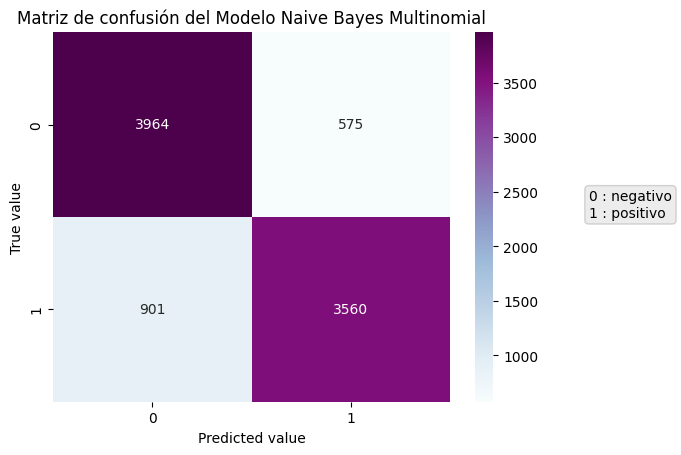

In [28]:
print('F1-Score: {}'.format(f1_score(y_test, y_pred, average='binary')))

confussionMatrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
sns.heatmap(confussionMatrix,cmap='BuPu', annot=True, fmt='g')
plt.xlabel('Predicted value')
plt.ylabel('True value')
plt.title("Matriz de confusión del Modelo Naive Bayes Multinomial")
plt.text(2.7, 1, f"0 : {labelEncoder.inverse_transform([0])[0]}\n1 : {labelEncoder.inverse_transform([1])[0]}", bbox=dict(boxstyle='round', facecolor='grey', alpha=0.15))
plt.show()

Mostramos las distintas métricas

In [29]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f"Accuracy: {str(accuracy)}")
print(f"Recall: {str(recall)}")
print(f"Precision: {str(precision)}")
print(f"f1 score: {str(f1)}")

Accuracy: 0.836
Recall: 0.7980273481282224
Precision: 0.8609431680773881
f1 score: 0.8282922289436948


Realizamos las predicciones de los datos que vamos a submitear a kaggle

In [30]:
y_pred = multinomialNBPipeline.predict(criticsTest["review"])

Agrupamos en el dataframe los valores predichos decodeados con el label encoder

In [31]:
kaggleResult = criticsTest.copy()
kaggleResult.drop(columns=["review"], inplace=True)

kaggleResult["sentimiento"] = labelEncoder.inverse_transform(y_pred)

kaggleResult.head(2)

,ID,sentimiento
0,60000,negativo
1,60001,negativo


Para exportar a Kaggle exportamos el csv. El `runNumber` es sólo un número que ponemos para no pisar los submits

In [32]:
kaggleResult.to_csv(f"submit_{runNumber}_grupo16_gpwin_naive_bayes_multinomial.csv", index=False)

Guardamos una serialización del modelo

In [33]:
filename = f'./naive_bayes_multinomial_model_{runNumber}.joblib'
modelInfo = {'model': multinomialNBPipeline}

joblib.dump(modelInfo, filename)

['./naive_bayes_multinomial_model_1.joblib']

## Naive Bayes con optimización de hiperparámetros

Creamos una pipeline que se encargará de realizar una vectorización siguiendo el modelo de BoW (Bag of Words) con el CountVectorizer, un transformador intermedio TfidfTransformer y posteriormente se aplicará un naive bayes para multinomiales.

El transformador TfidfTransformer normaliza la matriz del CountVectorizer por term-frequency (tf) o por term-frequency times inverse document-frequency (tf-idf), este último penaliza los tokens que se repiten mucho que usualmente no cargan con mucha información, como por ejemplo artículos.

Al aplicar este transformador luego del CountVectorizer, durante la optimización de hiperparámetros, se puede modificar el funcionamiento del transformador, incluso desactivándolo y utilizando el resultado del CountVectorizer directamente.

Se realizará una optimitimización de hiperparámetros de forma bayesiana con la librería optuna, de la misma manera que se hizo en el TP1. Dejamos un resumen del funcionamiento, que fue parte de la entrega del checkpoint 3 del TP1: 

- La optimización bayesiana es un enfoque efectivo para optimizar hiperparámetros, ya que a diferencia de los métodos de grid search y random search, aprovecha los resultados de evaluaciones previas para tomar decisiones más inteligentes sobre el siguiente conjunto de hiperparámetros a explorar. Trata la búsqueda de hiperparámetros óptimos como un problema de optimización, guiado por un modelo probabilístico que estima la probabilidad de lograr un resultado deseado con una combinación particular de hiperparámetros. Este enfoque reduce la cantidad de evaluaciones de la función objetivo necesarias para encontrar una buena solución, lo que lo hace especialmente valioso cuando la función objetivo es desconocida, que suele ser el caso. Varios modelos probabilísticos, como los procesos gaussianos, la regresión de random forests y los estimadores de Parzen estructurados en árboles (tree-structured Parzen estimators -TPE), sirven como modelos sustitutos para acelerar el proceso de optimización.

- Usaremos la librería optuna que automatiza y agiliza el proceso de ajuste de hiperparámetros, esta es la que utiliza técnicas de optimización bayesiana mencionada anteriormente, para recorrer el espacio de hiperparámetros de manera eficiente. Uno de sus fuertes es que es agnóstica al framework, por lo que se puede utilizar con diversos modelos de machine learning. 

Hay 3 grupos de hiperparámetros que optimizaremos: los del CountVectorizer, los del transformer Tfidf y los del modelo naive bayes multinomial.

Para el CountVectorizer optimizamos:
- strip_accents: forma de transformar los caracteres con tildes, puede ser utilizando una representación ascii, unicode o no hacer ninguna tranformación
- lowercase: pasa todos los caracteres a minúscula, puede estar activado o desactivado
- ngram_range: cantidad de n-gramas a utilizar para la tokenización, tomamos que puede ser unigramas, bigramas o ambos
- binary: si está en true, todas las cuentas que son distintas de cero se ponen en 1, puede servir porque estamos modelando un evento binario
- analyzer: lo tendremos seteado en word, así que un unigrama será una palabra y un bigrama serán dos palabras

Para el transformer Tfidf optimizamos:
- norm: tipo de normalización, puede estar desactivado o ser l1 (suma de los valores absolutos de las componentes del vector es 1) o l2 (suma de los valores absolutos al cuadrado de las componentes del vector es 1)
- use_idf: habilita o desabilita el uso del inverse document frequency
- sublinear_tf: aplica un escalado de term frequency sublineal, lo reemplaza por 1 + log(tf)

Para el modelo naive bayes multinomial optimizamos:
- alpha: parámetro de suavizado aditivo Laplace/Lidstone
- force_alpha: forzar el alpha si es muy pequeño

Creamos la función objetivo que vamos a optimizar

In [29]:
def objective(trial):

    parametersVectorizer = {
        'strip_accents': trial.suggest_categorical('strip_accents', ['ascii', 'unicode', None]),
        'lowercase': trial.suggest_categorical('lowercase', [True, False]),
        'ngram_range': trial.suggest_categorical('ngram_range', [(1,1), (1,2), (2,2)]),
        'binary': trial.suggest_categorical('binary', [True, False]),
        'analyzer': 'word'
    }

    parametersTransformer = {
        'norm': trial.suggest_categorical('norm', ['l1', 'l2', None]),
        'use_idf': trial.suggest_categorical('use_idf', [True, False]),
        'sublinear_tf': trial.suggest_categorical('sublinear_tf', [True, False]),
    }

    parametersModel = {
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
        'force_alpha': trial.suggest_categorical('force_alpha', [True, False]),
    }

    multinomialNBPipeline = Pipeline(steps=[
        ('vectorizer', CountVectorizer(**parametersVectorizer)),
        ('tfidfTransformer', TfidfTransformer(**parametersTransformer)),
        ('multinomialNB', MultinomialNB(**parametersModel))
    ])

    multinomialNBPipeline.fit(x_train, y_train)
    y_pred = multinomialNBPipeline.predict(x_test)

    return f1_score(y_test, y_pred, average='binary')


Creamos un study que va a ser donde corramos el "estudio de maximizar la función objetivo" definida arriba (que optimiza el f1 score)

In [30]:
study = optuna.create_study(direction='maximize')

[I 2023-11-19 08:02:04,808] A new study created in memory with name: no-name-6607a62c-63e8-439d-aa86-af4fc2eb559e


El método de sampleo de hiperparámetros que seguirá la optimización bayesiana será con el tree-structured Parzen estimators -TPE

In [31]:
study.sampler.__class__.__name__

'TPESampler'

Ejecutamos el estudio

In [32]:
study.optimize(objective, n_trials=200, show_progress_bar=True, n_jobs=3)

Best trial: 1. Best value: 0.846231:   0%|          | 1/200 [01:09<3:51:59, 69.95s/it]

[I 2023-11-19 08:03:14,763] Trial 1 finished with value: 0.8462311557788945 and parameters: {'strip_accents': None, 'lowercase': False, 'ngram_range': (1, 2), 'binary': False, 'norm': 'l1', 'use_idf': False, 'sublinear_tf': True, 'alpha': 3.118179525991605e-08, 'force_alpha': False}. Best is trial 1 with value: 0.8462311557788945.


Best trial: 1. Best value: 0.846231:   0%|          | 1/200 [01:21<3:51:59, 69.95s/it]

[I 2023-11-19 08:03:26,018] Trial 0 finished with value: 0.851765229981067 and parameters: {'strip_accents': 'unicode', 'lowercase': True, 'ngram_range': (1, 2), 'binary': False, 'norm': 'l1', 'use_idf': False, 'sublinear_tf': False, 'alpha': 1.4533355386325155e-07, 'force_alpha': False}. Best is trial 0 with value: 0.851765229981067.


Best trial: 0. Best value: 0.851765:   1%|          | 2/200 [01:24<1:58:46, 35.99s/it]

[I 2023-11-19 08:03:28,761] Trial 2 finished with value: 0.809800850302081 and parameters: {'strip_accents': 'unicode', 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': False, 'alpha': 3.576205194460432e-06, 'force_alpha': True}. Best is trial 0 with value: 0.851765229981067.


Best trial: 0. Best value: 0.851765:   2%|▏         | 3/200 [01:52<1:09:38, 21.21s/it]

[I 2023-11-19 08:03:56,554] Trial 4 finished with value: 0.8579646017699114 and parameters: {'strip_accents': 'ascii', 'lowercase': True, 'ngram_range': (1, 1), 'binary': False, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.299221773353175, 'force_alpha': True}. Best is trial 4 with value: 0.8579646017699114.


Best trial: 4. Best value: 0.857965:   2%|▏         | 4/200 [01:54<1:16:52, 23.54s/it]

[I 2023-11-19 08:03:58,745] Trial 3 finished with value: 0.8544579930641011 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (2, 2), 'binary': True, 'norm': 'l1', 'use_idf': False, 'sublinear_tf': False, 'alpha': 2.1130389240131405e-05, 'force_alpha': True}. Best is trial 4 with value: 0.8579646017699114.


Best trial: 4. Best value: 0.857965:   3%|▎         | 6/200 [02:22<1:03:41, 19.70s/it]

[I 2023-11-19 08:04:25,983] Trial 6 finished with value: 0.822429906542056 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (1, 1), 'binary': False, 'norm': 'l1', 'use_idf': False, 'sublinear_tf': False, 'alpha': 1.210180687648028e-07, 'force_alpha': True}. Best is trial 4 with value: 0.8579646017699114.


Best trial: 4. Best value: 0.857965:   3%|▎         | 6/200 [02:31<1:03:41, 19.70s/it]

[I 2023-11-19 08:04:36,018] Trial 7 finished with value: 0.7968428277282087 and parameters: {'strip_accents': 'unicode', 'lowercase': True, 'ngram_range': (1, 1), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.07931604431384237, 'force_alpha': True}. Best is trial 4 with value: 0.8579646017699114.


Best trial: 4. Best value: 0.857965:   4%|▎         | 7/200 [02:35<52:43, 16.39s/it]  

[I 2023-11-19 08:04:39,872] Trial 5 finished with value: 0.8735195530726256 and parameters: {'strip_accents': 'unicode', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': False, 'sublinear_tf': True, 'alpha': 6.727242319658597e-05, 'force_alpha': True}. Best is trial 5 with value: 0.8735195530726256.


Best trial: 5. Best value: 0.87352:   4%|▍         | 8/200 [02:42<40:07, 12.54s/it] 

[I 2023-11-19 08:04:47,054] Trial 8 finished with value: 0.8512855363008267 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 1), 'binary': False, 'norm': 'l2', 'use_idf': False, 'sublinear_tf': True, 'alpha': 0.4567764957357717, 'force_alpha': False}. Best is trial 5 with value: 0.8735195530726256.


Best trial: 5. Best value: 0.87352:   4%|▍         | 9/200 [02:52<34:05, 10.71s/it]

[I 2023-11-19 08:04:56,576] Trial 9 finished with value: 0.8510254676583278 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (1, 1), 'binary': False, 'norm': 'l2', 'use_idf': False, 'sublinear_tf': True, 'alpha': 0.004193869520249624, 'force_alpha': True}. Best is trial 5 with value: 0.8735195530726256.


Best trial: 5. Best value: 0.87352:   5%|▌         | 10/200 [03:06<32:54, 10.39s/it]

[I 2023-11-19 08:05:10,691] Trial 10 finished with value: 0.756768953068592 and parameters: {'strip_accents': 'unicode', 'lowercase': True, 'ngram_range': (1, 1), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': False, 'alpha': 1.8764805825998673e-06, 'force_alpha': True}. Best is trial 5 with value: 0.8735195530726256.


Best trial: 5. Best value: 0.87352:   6%|▌         | 12/200 [03:14<32:39, 10.42s/it]

[I 2023-11-19 08:05:18,655] Trial 11 finished with value: 0.7917040358744395 and parameters: {'strip_accents': 'unicode', 'lowercase': False, 'ngram_range': (1, 1), 'binary': False, 'norm': 'l2', 'use_idf': True, 'sublinear_tf': True, 'alpha': 3.7649153232810966e-05, 'force_alpha': True}. Best is trial 5 with value: 0.8735195530726256.


Best trial: 5. Best value: 0.87352:   6%|▌         | 12/200 [03:57<32:39, 10.42s/it]

[I 2023-11-19 08:06:01,812] Trial 12 finished with value: 0.8421052631578948 and parameters: {'strip_accents': 'unicode', 'lowercase': False, 'ngram_range': (2, 2), 'binary': True, 'norm': 'l2', 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.001042871711412102, 'force_alpha': False}. Best is trial 5 with value: 0.8735195530726256.


Best trial: 5. Best value: 0.87352:   6%|▋         | 13/200 [04:01<1:03:46, 20.46s/it]

[I 2023-11-19 08:06:06,116] Trial 13 finished with value: 0.8627583108715184 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (2, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.000681637175609074, 'force_alpha': True}. Best is trial 5 with value: 0.8735195530726256.


Best trial: 5. Best value: 0.87352:   7%|▋         | 14/200 [04:08<47:50, 15.44s/it]  

[I 2023-11-19 08:06:12,546] Trial 14 finished with value: 0.860864682762493 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (2, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.0006068078265966345, 'force_alpha': True}. Best is trial 5 with value: 0.8735195530726256.


Best trial: 5. Best value: 0.87352:   8%|▊         | 16/200 [04:55<1:10:27, 22.97s/it]

[I 2023-11-19 08:06:59,916] Trial 16 finished with value: 0.8704616763783056 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (2, 2), 'binary': True, 'norm': 'l1', 'use_idf': False, 'sublinear_tf': True, 'alpha': 0.0003251925480221229, 'force_alpha': True}. Best is trial 5 with value: 0.8735195530726256.


Best trial: 5. Best value: 0.87352:   8%|▊         | 16/200 [05:03<1:10:27, 22.97s/it]

[I 2023-11-19 08:07:07,522] Trial 17 finished with value: 0.8639677021419759 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (2, 2), 'binary': True, 'norm': 'l1', 'use_idf': False, 'sublinear_tf': True, 'alpha': 0.0001523954067255191, 'force_alpha': True}. Best is trial 5 with value: 0.8735195530726256.


Best trial: 5. Best value: 0.87352:   8%|▊         | 17/200 [05:06<56:45, 18.61s/it]  

[I 2023-11-19 08:07:10,644] Trial 15 finished with value: 0.8814501779359429 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.002581418168633027, 'force_alpha': True}. Best is trial 15 with value: 0.8814501779359429.


Best trial: 15. Best value: 0.88145:   9%|▉         | 18/200 [06:03<42:18, 13.95s/it]

[I 2023-11-19 08:08:07,662] Trial 18 finished with value: 0.8756285618504861 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': False, 'sublinear_tf': True, 'alpha': 0.00011182814586346604, 'force_alpha': True}. Best is trial 15 with value: 0.8814501779359429.


Best trial: 15. Best value: 0.88145:  10%|▉         | 19/200 [06:11<1:21:10, 26.91s/it]

[I 2023-11-19 08:08:15,778] Trial 19 finished with value: 0.8750835003340014 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': False, 'sublinear_tf': True, 'alpha': 0.01787646234639089, 'force_alpha': True}. Best is trial 15 with value: 0.8814501779359429.


Best trial: 15. Best value: 0.88145:  10%|█         | 20/200 [06:17<1:03:53, 21.29s/it]

[I 2023-11-19 08:08:21,662] Trial 20 finished with value: 0.8830046532240196 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.011432681569049998, 'force_alpha': False}. Best is trial 20 with value: 0.8830046532240196.


Best trial: 20. Best value: 0.883005:  11%|█         | 22/200 [07:13<1:24:05, 28.34s/it]

[I 2023-11-19 08:09:18,173] Trial 21 finished with value: 0.8334657736405948 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.01473013478477092, 'force_alpha': False}. Best is trial 20 with value: 0.8830046532240196.


Best trial: 20. Best value: 0.883005:  11%|█         | 22/200 [07:25<1:24:05, 28.34s/it]

[I 2023-11-19 08:09:30,343] Trial 22 finished with value: 0.8337497161026572 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.01606164454007886, 'force_alpha': False}. Best is trial 20 with value: 0.8830046532240196.


Best trial: 20. Best value: 0.883005:  12%|█▏        | 23/200 [07:27<1:09:47, 23.66s/it]

[I 2023-11-19 08:09:31,538] Trial 23 finished with value: 0.8831744624251828 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.010730622592760928, 'force_alpha': False}. Best is trial 23 with value: 0.8831744624251828.


Best trial: 23. Best value: 0.883174:  12%|█▏        | 24/200 [08:21<49:57, 17.03s/it]  

[I 2023-11-19 08:10:25,615] Trial 24 finished with value: 0.883079319167872 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.0033576074648884566, 'force_alpha': False}. Best is trial 23 with value: 0.8831744624251828.


Best trial: 23. Best value: 0.883174:  12%|█▎        | 25/200 [08:36<1:22:35, 28.31s/it]

[I 2023-11-19 08:10:41,059] Trial 26 finished with value: 0.8826604382159938 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.003113806945789398, 'force_alpha': False}. Best is trial 23 with value: 0.8831744624251828.


Best trial: 23. Best value: 0.883174:  13%|█▎        | 26/200 [08:37<1:10:29, 24.31s/it]

[I 2023-11-19 08:10:41,205] Trial 25 finished with value: 0.8825100133511349 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.0029901090018972674, 'force_alpha': False}. Best is trial 23 with value: 0.8831744624251828.


Best trial: 23. Best value: 0.883174:  14%|█▍        | 28/200 [09:18<1:09:34, 24.27s/it]

[I 2023-11-19 08:11:23,604] Trial 27 finished with value: 0.875793694998329 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.08000280715360553, 'force_alpha': False}. Best is trial 23 with value: 0.8831744624251828.


Best trial: 23. Best value: 0.883174:  14%|█▍        | 28/200 [09:51<1:09:34, 24.27s/it]

[I 2023-11-19 08:11:56,455] Trial 28 finished with value: 0.874359545555803 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.10323542974403357, 'force_alpha': False}. Best is trial 23 with value: 0.8831744624251828.


Best trial: 23. Best value: 0.883174:  15%|█▌        | 30/200 [09:53<54:53, 19.38s/it]  

[I 2023-11-19 08:11:56,980] Trial 29 finished with value: 0.875668449197861 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.08131923626040949, 'force_alpha': False}. Best is trial 23 with value: 0.8831744624251828.


Best trial: 23. Best value: 0.883174:  15%|█▌        | 30/200 [10:24<54:53, 19.38s/it]

[I 2023-11-19 08:12:28,283] Trial 30 finished with value: 0.8691016333938294 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l2', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.9776137403590588, 'force_alpha': False}. Best is trial 23 with value: 0.8831744624251828.


Best trial: 23. Best value: 0.883174:  16%|█▌        | 31/200 [11:04<1:04:24, 22.87s/it]

[I 2023-11-19 08:13:08,107] Trial 31 finished with value: 0.8693478754828449 and parameters: {'strip_accents': None, 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l2', 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.9816757973312613, 'force_alpha': False}. Best is trial 23 with value: 0.8831744624251828.


Best trial: 23. Best value: 0.883174:  16%|█▋        | 33/200 [11:06<56:06, 20.16s/it]  

[I 2023-11-19 08:13:11,113] Trial 32 finished with value: 0.8705003395970117 and parameters: {'strip_accents': None, 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l2', 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.7043068450851714, 'force_alpha': False}. Best is trial 23 with value: 0.8831744624251828.


Best trial: 23. Best value: 0.883174:  16%|█▋        | 33/200 [11:35<56:06, 20.16s/it]

[I 2023-11-19 08:13:40,003] Trial 33 finished with value: 0.8830188679245282 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.006528214410661109, 'force_alpha': False}. Best is trial 23 with value: 0.8831744624251828.


Best trial: 23. Best value: 0.883174:  17%|█▋        | 34/200 [12:11<1:04:02, 23.15s/it]

[I 2023-11-19 08:14:16,095] Trial 34 finished with value: 0.8826009764758099 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.006960494655347941, 'force_alpha': False}. Best is trial 23 with value: 0.8831744624251828.


Best trial: 23. Best value: 0.883174:  18%|█▊        | 35/200 [12:14<1:13:21, 26.68s/it]

[I 2023-11-19 08:14:18,416] Trial 35 finished with value: 0.8830188679245282 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.006569307145917452, 'force_alpha': False}. Best is trial 23 with value: 0.8831744624251828.


Best trial: 23. Best value: 0.883174:  18%|█▊        | 36/200 [12:42<53:30, 19.57s/it]  

[I 2023-11-19 08:14:46,187] Trial 36 finished with value: 0.8836436170212766 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.009387919372203422, 'force_alpha': False}. Best is trial 36 with value: 0.8836436170212766.


Best trial: 36. Best value: 0.883644:  19%|█▉        | 38/200 [13:19<1:11:45, 26.58s/it]

[I 2023-11-19 08:15:23,457] Trial 37 finished with value: 0.8800000000000001 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': False, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.027171828173760508, 'force_alpha': False}. Best is trial 36 with value: 0.8836436170212766.


Best trial: 36. Best value: 0.883644:  19%|█▉        | 38/200 [13:22<1:11:45, 26.58s/it]

[I 2023-11-19 08:15:26,902] Trial 38 finished with value: 0.8790161754930201 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': False, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.03202547091993271, 'force_alpha': False}. Best is trial 36 with value: 0.8836436170212766.


Best trial: 36. Best value: 0.883644:  20%|█▉        | 39/200 [13:47<52:33, 19.59s/it]  

[I 2023-11-19 08:15:51,859] Trial 39 finished with value: 0.8783244680851064 and parameters: {'strip_accents': 'ascii', 'lowercase': True, 'ngram_range': (1, 2), 'binary': False, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.037264822897143744, 'force_alpha': False}. Best is trial 36 with value: 0.8836436170212766.


Best trial: 36. Best value: 0.883644:  20%|██        | 40/200 [14:26<56:53, 21.33s/it]

[I 2023-11-19 08:16:30,262] Trial 40 finished with value: 0.8789497107254116 and parameters: {'strip_accents': 'ascii', 'lowercase': True, 'ngram_range': (1, 2), 'binary': False, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.0016643771265793406, 'force_alpha': False}. Best is trial 36 with value: 0.8836436170212766.


Best trial: 36. Best value: 0.883644:  21%|██        | 42/200 [14:30<51:40, 19.62s/it]  

[I 2023-11-19 08:16:34,906] Trial 41 finished with value: 0.8778310833426308 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.0014404189413535651, 'force_alpha': False}. Best is trial 36 with value: 0.8836436170212766.


Best trial: 36. Best value: 0.883644:  21%|██        | 42/200 [14:54<51:40, 19.62s/it]

[I 2023-11-19 08:16:58,626] Trial 42 finished with value: 0.8225733634311512 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.0009331155421286427, 'force_alpha': False}. Best is trial 36 with value: 0.8836436170212766.


Best trial: 36. Best value: 0.883644:  22%|██▏       | 43/200 [15:36<54:43, 20.91s/it]

[I 2023-11-19 08:17:40,342] Trial 43 finished with value: 0.8831168831168832 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.006148076099281946, 'force_alpha': False}. Best is trial 36 with value: 0.8836436170212766.


Best trial: 36. Best value: 0.883644:  22%|██▏       | 44/200 [15:43<1:10:59, 27.30s/it]

[I 2023-11-19 08:17:47,818] Trial 44 finished with value: 0.8835350283113134 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.005789171656894466, 'force_alpha': False}. Best is trial 36 with value: 0.8836436170212766.


Best trial: 36. Best value: 0.883644:  22%|██▎       | 45/200 [16:01<54:55, 21.26s/it]  

[I 2023-11-19 08:18:05,794] Trial 45 finished with value: 0.8826009764758099 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.006924033987607052, 'force_alpha': False}. Best is trial 36 with value: 0.8836436170212766.


Best trial: 36. Best value: 0.883644:  23%|██▎       | 46/200 [16:16<52:12, 20.34s/it]

[I 2023-11-19 08:18:20,818] Trial 47 finished with value: 0.8522916435467762 and parameters: {'strip_accents': 'unicode', 'lowercase': False, 'ngram_range': (1, 1), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.004557177139818539, 'force_alpha': False}. Best is trial 36 with value: 0.8836436170212766.


Best trial: 36. Best value: 0.883644:  24%|██▎       | 47/200 [16:39<47:57, 18.81s/it]

[I 2023-11-19 08:18:44,110] Trial 48 finished with value: 0.8592543569380102 and parameters: {'strip_accents': 'unicode', 'lowercase': False, 'ngram_range': (1, 1), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.3179233707711771, 'force_alpha': False}. Best is trial 36 with value: 0.8836436170212766.


Best trial: 36. Best value: 0.883644:  24%|██▍       | 48/200 [16:46<51:07, 20.18s/it]

[I 2023-11-19 08:18:50,576] Trial 46 finished with value: 0.8840724686006446 and parameters: {'strip_accents': 'unicode', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.004906358714967386, 'force_alpha': False}. Best is trial 46 with value: 0.8840724686006446.


Best trial: 46. Best value: 0.884072:  25%|██▌       | 50/200 [17:42<1:09:20, 27.74s/it]

[I 2023-11-19 08:19:46,704] Trial 49 finished with value: 0.8701848140725895 and parameters: {'strip_accents': 'unicode', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.2065081020407926, 'force_alpha': False}. Best is trial 46 with value: 0.8840724686006446.


Best trial: 46. Best value: 0.884072:  26%|██▌       | 51/200 [17:53<56:27, 22.74s/it]  

[I 2023-11-19 08:19:57,607] Trial 50 finished with value: 0.8469702156795619 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.17532992316639387, 'force_alpha': False}. Best is trial 46 with value: 0.8840724686006446.


Best trial: 46. Best value: 0.884072:  26%|██▌       | 51/200 [17:55<56:27, 22.74s/it]

[I 2023-11-19 08:20:00,298] Trial 51 finished with value: 0.8089710357263609 and parameters: {'strip_accents': 'unicode', 'lowercase': False, 'ngram_range': (2, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.0003740374514819936, 'force_alpha': False}. Best is trial 46 with value: 0.8840724686006446.


Best trial: 46. Best value: 0.884072:  26%|██▌       | 52/200 [18:40<41:45, 16.93s/it]

[I 2023-11-19 08:20:44,274] Trial 52 finished with value: 0.8338430173292559 and parameters: {'strip_accents': 'unicode', 'lowercase': False, 'ngram_range': (2, 2), 'binary': True, 'norm': None, 'use_idf': False, 'sublinear_tf': True, 'alpha': 0.00048258311242265866, 'force_alpha': False}. Best is trial 46 with value: 0.8840724686006446.


Best trial: 46. Best value: 0.884072:  26%|██▋       | 53/200 [19:16<1:01:03, 24.92s/it]

[I 2023-11-19 08:21:20,471] Trial 53 finished with value: 0.8732646663681147 and parameters: {'strip_accents': 'unicode', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.00042267652072729806, 'force_alpha': False}. Best is trial 46 with value: 0.8840724686006446.


Best trial: 46. Best value: 0.884072:  27%|██▋       | 54/200 [19:18<1:09:01, 28.36s/it]

[I 2023-11-19 08:21:23,202] Trial 54 finished with value: 0.8807932263814617 and parameters: {'strip_accents': 'unicode', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.0014979743052456406, 'force_alpha': False}. Best is trial 46 with value: 0.8840724686006446.


Best trial: 46. Best value: 0.884072:  28%|██▊       | 55/200 [20:13<49:53, 20.64s/it]  

[I 2023-11-19 08:22:18,245] Trial 55 finished with value: 0.8806053187938133 and parameters: {'strip_accents': 'unicode', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.002301937878760824, 'force_alpha': False}. Best is trial 46 with value: 0.8840724686006446.


Best trial: 46. Best value: 0.884072:  28%|██▊       | 56/200 [20:26<1:14:01, 30.85s/it]

[I 2023-11-19 08:22:30,630] Trial 56 finished with value: 0.8798397863818425 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.0019669812989741623, 'force_alpha': False}. Best is trial 46 with value: 0.8840724686006446.


Best trial: 46. Best value: 0.884072:  28%|██▊       | 57/200 [20:29<1:01:04, 25.62s/it]

[I 2023-11-19 08:22:34,426] Trial 57 finished with value: 0.8794404973357016 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.03570001701535621, 'force_alpha': False}. Best is trial 46 with value: 0.8840724686006446.


Best trial: 46. Best value: 0.884072:  29%|██▉       | 58/200 [20:54<44:56, 18.99s/it]  

[I 2023-11-19 08:22:57,744] Trial 59 finished with value: 0.8574270557029178 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 1), 'binary': True, 'norm': 'l1', 'use_idf': False, 'sublinear_tf': True, 'alpha': 0.04037932427611838, 'force_alpha': False}. Best is trial 46 with value: 0.8840724686006446.


Best trial: 46. Best value: 0.884072:  30%|██▉       | 59/200 [20:55<47:40, 20.29s/it]

[I 2023-11-19 08:22:59,905] Trial 60 finished with value: 0.8609974565962623 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 1), 'binary': False, 'norm': 'l1', 'use_idf': False, 'sublinear_tf': True, 'alpha': 0.012205060238563048, 'force_alpha': False}. Best is trial 46 with value: 0.8840724686006446.


Best trial: 46. Best value: 0.884072:  30%|███       | 60/200 [21:03<34:32, 14.80s/it]

[I 2023-11-19 08:23:08,445] Trial 58 finished with value: 0.8712871287128713 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': False, 'sublinear_tf': True, 'alpha': 0.04074154863911245, 'force_alpha': False}. Best is trial 46 with value: 0.8840724686006446.


Best trial: 46. Best value: 0.884072:  30%|███       | 61/200 [22:01<29:43, 12.83s/it]

[I 2023-11-19 08:24:05,977] Trial 61 finished with value: 0.8797159343098091 and parameters: {'strip_accents': 'ascii', 'lowercase': True, 'ngram_range': (1, 2), 'binary': False, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.012046915363765445, 'force_alpha': False}. Best is trial 46 with value: 0.8840724686006446.


Best trial: 46. Best value: 0.884072:  32%|███▏      | 63/200 [22:04<43:31, 19.06s/it]  

[I 2023-11-19 08:24:08,531] Trial 62 finished with value: 0.8798044878915797 and parameters: {'strip_accents': 'ascii', 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.0037979492271019957, 'force_alpha': False}. Best is trial 46 with value: 0.8840724686006446.


Best trial: 46. Best value: 0.884072:  32%|███▏      | 63/200 [22:14<43:31, 19.06s/it]

[I 2023-11-19 08:24:18,651] Trial 63 finished with value: 0.8841964881084685 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.004799196315568834, 'force_alpha': False}. Best is trial 63 with value: 0.8841964881084685.


Best trial: 64. Best value: 0.884444:  32%|███▏      | 64/200 [23:11<37:18, 16.46s/it]

[I 2023-11-19 08:25:16,252] Trial 64 finished with value: 0.8844444444444444 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.00473836153395484, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  33%|███▎      | 66/200 [23:14<46:25, 20.79s/it]  

[I 2023-11-19 08:25:18,743] Trial 65 finished with value: 0.8828948828948829 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.006493840078803552, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  33%|███▎      | 66/200 [23:23<46:25, 20.79s/it]

[I 2023-11-19 08:25:28,428] Trial 66 finished with value: 0.8798661461238148 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.0010960200471319787, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  34%|███▎      | 67/200 [24:20<39:09, 17.66s/it]

[I 2023-11-19 08:26:25,057] Trial 67 finished with value: 0.8515096890491214 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l2', 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.0008502016285947963, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  34%|███▍      | 69/200 [24:21<45:03, 20.64s/it]  

[I 2023-11-19 08:26:25,969] Trial 69 finished with value: 0.8395228449246005 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (2, 2), 'binary': True, 'norm': 'l2', 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.0007343574381782379, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  34%|███▍      | 69/200 [24:25<45:03, 20.64s/it]

[I 2023-11-19 08:26:29,495] Trial 68 finished with value: 0.8517016001803022 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l2', 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.0008830673764447198, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  36%|███▌      | 71/200 [25:25<1:02:05, 28.88s/it]

[I 2023-11-19 08:27:29,608] Trial 70 finished with value: 0.881965382467895 and parameters: {'strip_accents': None, 'lowercase': False, 'ngram_range': (2, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.020007452728176642, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  36%|███▌      | 72/200 [25:38<51:57, 24.36s/it]  

[I 2023-11-19 08:27:43,092] Trial 71 finished with value: 0.8823333703005434 and parameters: {'strip_accents': None, 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.017582515831367124, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  36%|███▋      | 73/200 [25:40<36:53, 17.43s/it]

[I 2023-11-19 08:27:44,629] Trial 72 finished with value: 0.8814461572585118 and parameters: {'strip_accents': None, 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.015602225031896809, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  36%|███▋      | 73/200 [26:34<36:53, 17.43s/it]

[I 2023-11-19 08:28:38,463] Trial 73 finished with value: 0.881744354210702 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.002763999885072365, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  37%|███▋      | 74/200 [26:49<1:00:26, 28.78s/it]

[I 2023-11-19 08:28:54,323] Trial 74 finished with value: 0.8837209302325582 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.0040122233117783224, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  38%|███▊      | 76/200 [26:50<35:48, 17.33s/it]  

[I 2023-11-19 08:28:54,948] Trial 75 finished with value: 0.8832035595105674 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.0033872393107085385, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  38%|███▊      | 76/200 [27:44<35:48, 17.33s/it]

[I 2023-11-19 08:29:48,490] Trial 76 finished with value: 0.8844444444444444 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.004731655397660727, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  39%|███▉      | 78/200 [28:00<49:57, 24.57s/it]

[I 2023-11-19 08:30:04,846] Trial 77 finished with value: 0.8836693995125194 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.009487673090200465, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  40%|███▉      | 79/200 [28:01<35:08, 17.42s/it]

[I 2023-11-19 08:30:05,514] Trial 78 finished with value: 0.8830506595721095 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.010515410865971679, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  40%|███▉      | 79/200 [28:49<35:08, 17.42s/it]

[I 2023-11-19 08:30:54,158] Trial 79 finished with value: 0.8843204800533392 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.004676384524547445, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  40%|████      | 80/200 [29:12<55:47, 27.90s/it]

[I 2023-11-19 08:31:16,635] Trial 80 finished with value: 0.8691463141384719 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.00025256835829169633, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  41%|████      | 82/200 [29:13<35:16, 17.94s/it]

[I 2023-11-19 08:31:17,812] Trial 81 finished with value: 0.8831485587583148 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.008440199968225435, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  42%|████▏     | 83/200 [29:56<49:40, 25.47s/it]

[I 2023-11-19 08:32:00,824] Trial 82 finished with value: 0.8676371780515117 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.00020485422321068325, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  42%|████▏     | 84/200 [30:23<50:00, 25.87s/it]

[I 2023-11-19 08:32:27,434] Trial 83 finished with value: 0.8841449855459195 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.004338663025601454, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  42%|████▏     | 84/200 [30:24<50:00, 25.87s/it]

[I 2023-11-19 08:32:28,982] Trial 84 finished with value: 0.8841449855459195 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.004316744017715667, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  42%|████▎     | 85/200 [31:05<35:49, 18.69s/it]

[I 2023-11-19 08:33:09,206] Trial 85 finished with value: 0.8842690383546415 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.004465347100904576, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  44%|████▎     | 87/200 [31:35<49:44, 26.41s/it]

[I 2023-11-19 08:33:39,473] Trial 86 finished with value: 0.8838709677419355 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.004060231002539295, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  44%|████▍     | 88/200 [31:35<34:59, 18.74s/it]

[I 2023-11-19 08:33:40,358] Trial 87 finished with value: 0.8841449855459195 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.004308047025944401, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  44%|████▍     | 89/200 [32:14<45:40, 24.69s/it]

[I 2023-11-19 08:34:17,851] Trial 88 finished with value: 0.8843204800533392 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.004671628986829927, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  44%|████▍     | 89/200 [32:47<45:40, 24.69s/it]

[I 2023-11-19 08:34:52,008] Trial 89 finished with value: 0.879670818505338 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.0021237737474335125, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  45%|████▌     | 90/200 [32:58<50:10, 27.37s/it]

[I 2023-11-19 08:35:02,837] Trial 90 finished with value: 0.8798665183537265 and parameters: {'strip_accents': 'unicode', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.00211374837725792, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  46%|████▌     | 91/200 [33:22<40:44, 22.43s/it]

[I 2023-11-19 08:35:26,499] Trial 91 finished with value: 0.8802581793901625 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': False, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.0019218185367114596, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  46%|████▋     | 93/200 [33:55<46:08, 25.87s/it]

[I 2023-11-19 08:36:00,135] Trial 92 finished with value: 0.8784776318718005 and parameters: {'strip_accents': 'ascii', 'lowercase': True, 'ngram_range': (1, 2), 'binary': False, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.001360037561717375, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  47%|████▋     | 94/200 [34:13<41:34, 23.54s/it]

[I 2023-11-19 08:36:17,556] Trial 93 finished with value: 0.8808463251670379 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.0015694538598511718, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  47%|████▋     | 94/200 [34:28<41:34, 23.54s/it]

[I 2023-11-19 08:36:32,996] Trial 94 finished with value: 0.8832149200710481 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.006040676767183177, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  48%|████▊     | 95/200 [35:05<37:07, 21.21s/it]

[I 2023-11-19 08:37:09,850] Trial 95 finished with value: 0.8841964881084685 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.004838181184664341, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  48%|████▊     | 96/200 [35:22<44:36, 25.74s/it]

[I 2023-11-19 08:37:26,630] Trial 96 finished with value: 0.8841192170818506 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.004217647022857376, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  48%|████▊     | 97/200 [35:30<39:20, 22.92s/it]

[I 2023-11-19 08:37:34,772] Trial 98 finished with value: 0.7762588288904079 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 1), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.0029319622624525443, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  49%|████▉     | 98/200 [35:33<31:33, 18.57s/it]

[I 2023-11-19 08:37:37,554] Trial 97 finished with value: 0.8288757932910246 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.004265465321287182, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  50%|████▉     | 99/200 [35:40<23:15, 13.82s/it]

[I 2023-11-19 08:37:45,100] Trial 99 finished with value: 0.8597305058537662 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 1), 'binary': True, 'norm': 'l1', 'use_idf': False, 'sublinear_tf': False, 'alpha': 0.022826800291426474, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  50%|█████     | 101/200 [36:39<42:45, 25.91s/it]

[I 2023-11-19 08:38:44,354] Trial 100 finished with value: 0.8734275854391629 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': False, 'sublinear_tf': False, 'alpha': 0.025535990584668336, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  51%|█████     | 102/200 [36:41<30:32, 18.70s/it]

[I 2023-11-19 08:38:45,786] Trial 101 finished with value: 0.8735939414188663 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': False, 'sublinear_tf': False, 'alpha': 0.02231193719161518, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  51%|█████     | 102/200 [36:55<30:32, 18.70s/it]

[I 2023-11-19 08:38:59,391] Trial 102 finished with value: 0.8748462140700146 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.0005268167945164745, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  52%|█████▏    | 104/200 [37:48<44:54, 28.06s/it]

[I 2023-11-19 08:39:53,152] Trial 103 finished with value: 0.8824051475482582 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.007670146447707189, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  52%|█████▏    | 104/200 [37:48<44:54, 28.06s/it]

[I 2023-11-19 08:39:53,676] Trial 104 finished with value: 0.8815218600511737 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.0027166474791559467, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  52%|█████▎    | 105/200 [38:05<31:29, 19.89s/it]

[I 2023-11-19 08:40:09,991] Trial 105 finished with value: 0.8815482148815483 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.0026398668145356267, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  53%|█████▎    | 106/200 [38:58<29:45, 19.00s/it]

[I 2023-11-19 08:41:03,315] Trial 106 finished with value: 0.8840724686006446 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.004922829778924034, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  54%|█████▍    | 108/200 [38:59<31:17, 20.41s/it]

[I 2023-11-19 08:41:04,055] Trial 107 finished with value: 0.8840724686006446 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.00484295276885075, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  54%|█████▍    | 108/200 [39:15<31:17, 20.41s/it]

[I 2023-11-19 08:41:19,273] Trial 108 finished with value: 0.8843204800533392 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.004687970158806306, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  55%|█████▌    | 110/200 [39:54<37:50, 25.23s/it]

[I 2023-11-19 08:41:56,282] Trial 109 finished with value: 0.8670039347948285 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (2, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.0011568113435430913, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  55%|█████▌    | 110/200 [39:55<37:50, 25.23s/it]

[I 2023-11-19 08:42:00,103] Trial 110 finished with value: 0.8794992175273865 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (2, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.013741007409689043, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  56%|█████▌    | 111/200 [40:10<26:42, 18.00s/it]

[I 2023-11-19 08:42:14,110] Trial 111 finished with value: 0.8623065627470915 and parameters: {'strip_accents': 'ascii', 'lowercase': True, 'ngram_range': (2, 2), 'binary': True, 'norm': 'l2', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.01259652199470853, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  56%|█████▋    | 113/200 [41:04<40:45, 28.11s/it]

[I 2023-11-19 08:43:08,399] Trial 112 finished with value: 0.8706915972065781 and parameters: {'strip_accents': 'ascii', 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l2', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.014561706526369466, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  56%|█████▋    | 113/200 [41:06<40:45, 28.11s/it]

[I 2023-11-19 08:43:10,964] Trial 113 finished with value: 0.883494069393637 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.009089356027842999, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  57%|█████▋    | 114/200 [41:20<29:09, 20.34s/it]

[I 2023-11-19 08:43:24,526] Trial 114 finished with value: 0.8826009764758099 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.006955667427525702, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  57%|█████▊    | 115/200 [42:14<26:19, 18.58s/it]

[I 2023-11-19 08:44:18,890] Trial 115 finished with value: 0.8832982378366399 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.008906857799283132, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  58%|█████▊    | 117/200 [42:15<28:15, 20.43s/it]

[I 2023-11-19 08:44:19,844] Trial 116 finished with value: 0.8826009764758099 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.007255353194973885, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  58%|█████▊    | 117/200 [42:32<28:15, 20.43s/it]

[I 2023-11-19 08:44:36,555] Trial 117 finished with value: 0.8831053275497721 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.003788771472565884, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  60%|█████▉    | 119/200 [43:25<40:03, 29.67s/it]

[I 2023-11-19 08:45:30,374] Trial 118 finished with value: 0.8826604382159938 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.0031370808337158034, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  60%|██████    | 120/200 [43:26<28:02, 21.03s/it]

[I 2023-11-19 08:45:31,157] Trial 119 finished with value: 0.8832035595105674 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.0034038996225914404, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  60%|██████    | 120/200 [43:42<28:02, 21.03s/it]

[I 2023-11-19 08:45:46,594] Trial 120 finished with value: 0.8806868867082962 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.0013187439967893393, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  61%|██████    | 122/200 [44:33<37:28, 28.83s/it]

[I 2023-11-19 08:46:37,595] Trial 121 finished with value: 0.8807666592377981 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.001481951755839552, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  62%|██████▏   | 123/200 [44:34<26:23, 20.57s/it]

[I 2023-11-19 08:46:39,298] Trial 122 finished with value: 0.8793739519284517 and parameters: {'strip_accents': None, 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.0010080920400746265, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  62%|██████▏   | 123/200 [45:06<26:23, 20.57s/it]

[I 2023-11-19 08:47:10,653] Trial 123 finished with value: 0.8840257720506554 and parameters: {'strip_accents': 'unicode', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.0052182778729911745, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  62%|██████▎   | 125/200 [45:59<40:46, 32.61s/it]

[I 2023-11-19 08:48:04,080] Trial 125 finished with value: 0.8843204800533392 and parameters: {'strip_accents': 'unicode', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.004627674336653974, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  62%|██████▎   | 125/200 [46:00<40:46, 32.61s/it]

[I 2023-11-19 08:48:04,971] Trial 124 finished with value: 0.8840982331370151 and parameters: {'strip_accents': 'unicode', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.005123525147105733, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  63%|██████▎   | 126/200 [46:31<28:45, 23.32s/it]

[I 2023-11-19 08:48:35,464] Trial 126 finished with value: 0.8800623052959502 and parameters: {'strip_accents': 'unicode', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.0021756647102047634, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  64%|██████▎   | 127/200 [47:17<31:08, 25.60s/it]

[I 2023-11-19 08:49:21,323] Trial 127 finished with value: 0.8804275217100869 and parameters: {'strip_accents': 'unicode', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.001774570288961563, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  64%|██████▍   | 128/200 [47:28<38:07, 31.77s/it]

[I 2023-11-19 08:49:32,187] Trial 128 finished with value: 0.8806767586821015 and parameters: {'strip_accents': 'unicode', 'lowercase': False, 'ngram_range': (1, 2), 'binary': False, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.002121561272343731, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  64%|██████▍   | 129/200 [47:43<29:58, 25.34s/it]

[I 2023-11-19 08:49:47,996] Trial 129 finished with value: 0.8768956289027654 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': False, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.0006740672900418488, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  66%|██████▌   | 131/200 [48:26<32:50, 28.56s/it]

[I 2023-11-19 08:50:31,742] Trial 130 finished with value: 0.876324300211888 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': False, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.0006236586686752924, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  66%|██████▌   | 132/200 [48:42<27:55, 24.64s/it]

[I 2023-11-19 08:50:46,845] Trial 131 finished with value: 0.8831024930747923 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.009941554681419837, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  66%|██████▌   | 132/200 [48:56<27:55, 24.64s/it]

[I 2023-11-19 08:51:00,578] Trial 132 finished with value: 0.8314606741573034 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.009099388589013564, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  67%|██████▋   | 134/200 [49:48<33:41, 30.63s/it]

[I 2023-11-19 08:51:52,811] Trial 133 finished with value: 0.8831168831168832 and parameters: {'strip_accents': 'unicode', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.00615378159482301, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  68%|██████▊   | 135/200 [50:07<29:26, 27.17s/it]

[I 2023-11-19 08:52:12,096] Trial 134 finished with value: 0.8837570778283558 and parameters: {'strip_accents': 'unicode', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.005701863559085417, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  68%|██████▊   | 135/200 [50:22<29:26, 27.17s/it]

[I 2023-11-19 08:52:26,960] Trial 135 finished with value: 0.8836331334665778 and parameters: {'strip_accents': 'unicode', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.005657356886851805, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  68%|██████▊   | 136/200 [51:11<25:12, 23.64s/it]

[I 2023-11-19 08:53:16,353] Trial 136 finished with value: 0.8839742164925539 and parameters: {'strip_accents': 'unicode', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.005103917341270737, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  69%|██████▉   | 138/200 [51:31<28:33, 27.64s/it]

[I 2023-11-19 08:53:35,907] Trial 137 finished with value: 0.8832035595105674 and parameters: {'strip_accents': 'unicode', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.0038465946175991832, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  69%|██████▉   | 138/200 [51:40<28:33, 27.64s/it]

[I 2023-11-19 08:53:44,586] Trial 139 finished with value: 0.8498778592049745 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 1), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.0032780340101208065, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  70%|███████   | 140/200 [51:43<16:21, 16.36s/it]

[I 2023-11-19 08:53:47,956] Trial 138 finished with value: 0.8832035595105674 and parameters: {'strip_accents': 'unicode', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.0038391188846055905, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  70%|███████   | 140/200 [51:47<16:21, 16.36s/it]

[I 2023-11-19 08:53:52,120] Trial 140 finished with value: 0.860015467904099 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 1), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.01754663628370652, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  70%|███████   | 141/200 [52:44<12:48, 13.03s/it]

[I 2023-11-19 08:54:49,267] Trial 141 finished with value: 0.8819806816920174 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.01765258096022174, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  71%|███████   | 142/200 [52:52<26:39, 27.57s/it]

[I 2023-11-19 08:54:56,566] Trial 142 finished with value: 0.8821047957371225 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.017534450142862125, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  72%|███████▏  | 143/200 [53:10<19:06, 20.12s/it]

[I 2023-11-19 08:55:13,831] Trial 143 finished with value: 0.8809523809523809 and parameters: {'strip_accents': 'unicode', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.0023467722303436977, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  72%|███████▏  | 144/200 [54:05<18:02, 19.33s/it]

[I 2023-11-19 08:56:10,391] Trial 144 finished with value: 0.8813974187805963 and parameters: {'strip_accents': 'unicode', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.0024368800149354095, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  72%|███████▎  | 145/200 [54:16<27:52, 30.40s/it]

[I 2023-11-19 08:56:20,963] Trial 145 finished with value: 0.8808543775725888 and parameters: {'strip_accents': 'unicode', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.002314967451514494, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  73%|███████▎  | 146/200 [54:35<22:05, 24.54s/it]

[I 2023-11-19 08:56:39,714] Trial 146 finished with value: 0.8830506595721095 and parameters: {'strip_accents': 'unicode', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.010785263954256486, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  74%|███████▍  | 148/200 [55:33<28:43, 33.14s/it]

[I 2023-11-19 08:57:37,915] Trial 148 finished with value: 0.8832723644828734 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.01065440982627815, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.
[I 2023-11-19 08:57:38,409] Trial 147 finished with value: 0.8830046532240196 and parameters: {'strip_accents': 'unicode', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.011539977569336222, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  74%|███████▍  | 149/200 [55:48<28:10, 33.14s/it]

[I 2023-11-19 08:57:52,783] Trial 149 finished with value: 0.884 and parameters: {'strip_accents': None, 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.004916529495910476, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


[I 2023-11-19 08:58:41,994] Trial 151 finished with value: 0.8789936546810642 and parameters: {'strip_accents': 'ascii', 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': False, 'sublinear_tf': False, 'alpha': 0.00463274716550329, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  76%|███████▌  | 151/200 [56:41<22:55, 28.07s/it]

[I 2023-11-19 08:58:42,436] Trial 150 finished with value: 0.8773217662106549 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': False, 'sublinear_tf': False, 'alpha': 0.004807475416404683, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  76%|███████▌  | 152/200 [56:58<17:27, 21.82s/it]

[I 2023-11-19 08:59:02,604] Trial 152 finished with value: 0.8674182638105975 and parameters: {'strip_accents': 'ascii', 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l2', 'use_idf': False, 'sublinear_tf': False, 'alpha': 0.0014405117531724862, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  76%|███████▋  | 153/200 [57:52<16:11, 20.68s/it]

[I 2023-11-19 08:59:56,954] Trial 153 finished with value: 0.8826009764758099 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.007268983245221152, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  78%|███████▊  | 155/200 [57:56<16:46, 22.36s/it]

[I 2023-11-19 09:00:00,613] Trial 154 finished with value: 0.883079319167872 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.0033684564038277223, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  78%|███████▊  | 155/200 [58:10<16:46, 22.36s/it]

[I 2023-11-19 09:00:14,794] Trial 155 finished with value: 0.8827586206896552 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.0030520261014309004, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  78%|███████▊  | 156/200 [58:58<14:47, 20.17s/it]

[I 2023-11-19 09:01:02,280] Trial 156 finished with value: 0.8826604382159938 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.003101752321689609, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  78%|███████▊  | 157/200 [59:03<20:05, 28.05s/it]

[I 2023-11-19 09:01:08,068] Trial 157 finished with value: 0.8826009764758099 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.006908810153938196, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  79%|███████▉  | 158/200 [59:20<15:04, 21.53s/it]

[I 2023-11-19 09:01:25,031] Trial 158 finished with value: 0.8831168831168832 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.00625003609687458, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  80%|███████▉  | 159/200 [1:00:05<13:48, 20.22s/it]

[I 2023-11-19 09:02:09,662] Trial 159 finished with value: 0.830989110707804 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.007519029471770338, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  80%|████████  | 160/200 [1:00:14<18:20, 27.51s/it]

[I 2023-11-19 09:02:18,554] Trial 160 finished with value: 0.8807747968384726 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.00168826291515526, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  80%|████████  | 161/200 [1:00:31<14:13, 21.89s/it]

[I 2023-11-19 09:02:36,175] Trial 161 finished with value: 0.8261508879086077 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.0017724686446501578, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  81%|████████  | 162/200 [1:01:15<13:03, 20.61s/it]

[I 2023-11-19 09:03:20,015] Trial 162 finished with value: 0.8807482462977396 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'alpha': 0.001725842478235871, 'force_alpha': False}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  82%|████████▏ | 163/200 [1:01:25<17:01, 27.61s/it]

[I 2023-11-19 09:03:30,160] Trial 163 finished with value: 0.8842433003447125 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.004420147628817892, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  82%|████████▏ | 164/200 [1:01:41<13:19, 22.22s/it]

[I 2023-11-19 09:03:45,232] Trial 164 finished with value: 0.8841707425522455 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.004562874610412618, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  82%|████████▎ | 165/200 [1:02:26<11:53, 20.39s/it]

[I 2023-11-19 09:04:30,431] Trial 165 finished with value: 0.8842433003447125 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.004437864871509809, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  83%|████████▎ | 166/200 [1:02:34<15:42, 27.73s/it]

[I 2023-11-19 09:04:38,973] Trial 166 finished with value: 0.8841707425522455 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.0044853577328783775, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  84%|████████▎ | 167/200 [1:02:50<12:02, 21.91s/it]

[I 2023-11-19 09:04:54,537] Trial 167 finished with value: 0.8841192170818506 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.004247672516844963, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  84%|████████▍ | 168/200 [1:03:34<10:48, 20.28s/it]

[I 2023-11-19 09:05:38,797] Trial 168 finished with value: 0.8796161999330581 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.001035836182086164, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  84%|████████▍ | 169/200 [1:03:40<14:07, 27.34s/it]

[I 2023-11-19 09:05:44,689] Trial 169 finished with value: 0.8829550511793504 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.0036410128219520567, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  85%|████████▌ | 170/200 [1:04:00<10:16, 20.56s/it]

[I 2023-11-19 09:06:05,119] Trial 170 finished with value: 0.8831485587583148 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.008475666040612777, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  86%|████████▌ | 171/200 [1:04:42<09:57, 20.61s/it]

[I 2023-11-19 09:06:46,504] Trial 171 finished with value: 0.8819668483702304 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.0027909261270047396, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  86%|████████▌ | 172/200 [1:04:45<12:39, 27.14s/it]

[I 2023-11-19 09:06:50,368] Trial 172 finished with value: 0.883494069393637 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.009054724021317868, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  86%|████████▋ | 173/200 [1:05:12<08:56, 19.86s/it]

[I 2023-11-19 09:07:16,495] Trial 173 finished with value: 0.881619937694704 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.0027479098787442776, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  87%|████████▋ | 174/200 [1:05:47<09:28, 21.88s/it]

[I 2023-11-19 09:07:51,361] Trial 174 finished with value: 0.8844444444444444 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.004736311051621985, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  88%|████████▊ | 176/200 [1:05:53<07:49, 19.58s/it]

[I 2023-11-19 09:07:56,489] Trial 175 finished with value: 0.8835967059870911 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.003971848471494288, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  88%|████████▊ | 176/200 [1:06:26<07:49, 19.58s/it]

[I 2023-11-19 09:08:30,729] Trial 176 finished with value: 0.8843673560151213 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.004399366990459828, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  88%|████████▊ | 177/200 [1:06:41<09:09, 23.91s/it]

[I 2023-11-19 09:08:45,749] Trial 177 finished with value: 0.8790791238265534 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (2, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.013194026717229055, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  89%|████████▉ | 178/200 [1:06:45<07:49, 21.33s/it]

[I 2023-11-19 09:08:50,116] Trial 178 finished with value: 0.8794992175273865 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (2, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.013923844189320871, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  90%|████████▉ | 179/200 [1:07:17<05:36, 16.01s/it]

[I 2023-11-19 09:09:20,877] Trial 179 finished with value: 0.8433411606843342 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (2, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 5.533430980229045e-05, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  90%|█████████ | 180/200 [1:07:51<06:55, 20.75s/it]

[I 2023-11-19 09:09:55,278] Trial 180 finished with value: 0.8826989235378981 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.006837870334642786, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  90%|█████████ | 181/200 [1:07:52<07:49, 24.69s/it]

[I 2023-11-19 09:09:57,593] Trial 181 finished with value: 0.8830188679245282 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.006557605001453774, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  91%|█████████ | 182/200 [1:08:26<05:20, 17.83s/it]

[I 2023-11-19 09:10:29,919] Trial 182 finished with value: 0.8832149200710481 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.006199644315270235, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  92%|█████████▏| 183/200 [1:08:56<06:21, 22.45s/it]

[I 2023-11-19 09:11:00,908] Trial 183 finished with value: 0.8839484215206758 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.005009080405835628, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  92%|█████████▏| 184/200 [1:09:00<06:40, 25.00s/it]

[I 2023-11-19 09:11:04,752] Trial 184 finished with value: 0.8840982331370151 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.004607916628564569, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  92%|█████████▎| 185/200 [1:09:34<04:36, 18.42s/it]

[I 2023-11-19 09:11:38,691] Trial 185 finished with value: 0.8812729498164014 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.0024195916648736705, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  93%|█████████▎| 186/200 [1:10:03<05:24, 23.16s/it]

[I 2023-11-19 09:12:08,114] Trial 186 finished with value: 0.8809523809523809 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.0023744473452402943, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  94%|█████████▎| 187/200 [1:10:07<05:26, 25.13s/it]

[I 2023-11-19 09:12:12,013] Trial 187 finished with value: 0.8814501779359429 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.0025688475218068924, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  94%|█████████▍| 188/200 [1:10:40<03:42, 18.57s/it]

[I 2023-11-19 09:12:44,764] Trial 188 finished with value: 0.883079319167872 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.003350641952403653, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  95%|█████████▌| 190/200 [1:11:12<04:15, 25.51s/it]

[I 2023-11-19 09:13:16,732] Trial 189 finished with value: 0.862696349870042 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l2', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.003588866389906546, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  95%|█████████▌| 190/200 [1:11:14<04:15, 25.51s/it]

[I 2023-11-19 09:13:18,762] Trial 190 finished with value: 0.8630152456239413 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l2', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.0037616437652219017, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  96%|█████████▌| 192/200 [1:11:49<03:06, 23.31s/it]

[I 2023-11-19 09:13:52,813] Trial 191 finished with value: 0.8832723644828734 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.008696130949467442, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  96%|█████████▌| 192/200 [1:12:19<03:06, 23.31s/it]

[I 2023-11-19 09:14:23,829] Trial 192 finished with value: 0.8830765820680483 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.010855537516019842, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  96%|█████████▋| 193/200 [1:12:21<02:57, 25.41s/it]

[I 2023-11-19 09:14:25,608] Trial 193 finished with value: 0.8844444444444444 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.004719892245275808, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  97%|█████████▋| 194/200 [1:13:00<01:48, 18.14s/it]

[I 2023-11-19 09:15:04,234] Trial 194 finished with value: 0.8839484215206758 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.004886203586626292, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  98%|█████████▊| 196/200 [1:13:27<01:40, 25.06s/it]

[I 2023-11-19 09:15:31,160] Trial 195 finished with value: 0.8840724686006446 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.0049144307817552005, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444:  98%|█████████▊| 197/200 [1:13:28<00:53, 17.88s/it]

[I 2023-11-19 09:15:32,650] Trial 196 finished with value: 0.8506442577030812 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 1.4895584586106235e-05, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444: 100%|█████████▉| 199/200 [1:13:52<00:13, 13.91s/it]

[I 2023-11-19 09:15:57,386] Trial 198 finished with value: 0.8416269533414608 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 1), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.001160462243078409, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.
[I 2023-11-19 09:15:57,489] Trial 199 finished with value: 0.8599161703066402 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 1), 'binary': False, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.028139664314569657, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Best trial: 64. Best value: 0.884444: 100%|██████████| 200/200 [1:13:56<00:00, 22.18s/it]

[I 2023-11-19 09:16:01,656] Trial 197 finished with value: 0.8826009764758099 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'alpha': 0.007316456280750689, 'force_alpha': True}. Best is trial 64 with value: 0.8844444444444444.


Las 200 iteraciones del estudio tardaron 70 minutos en total

Seleccionamos el mejor trial (intento) con el mejor score y el mejor conjunto de hiperparámetros

In [33]:
bestTrial = study.best_trial
bestScore = bestTrial.value
hyperparameters = bestTrial.params

print('Cantidad de trials total: {}'.format(len(study.trials)))
print('Mejor f1score: ' + str(bestScore) + "\n")

for param, value in hyperparameters.items():
    print(f"{param}: {value}")

Cantidad de trials total: 200
Mejor f1score: 0.8844444444444444

strip_accents: ascii
lowercase: False
ngram_range: (1, 2)
binary: True
norm: l1
use_idf: True
sublinear_tf: True
alpha: 0.00473836153395484
force_alpha: False


Recreamos una pipeline con estos mejores parámetros

In [34]:
runNumber = 4

parametersVectorizer = {
    'strip_accents': hyperparameters["strip_accents"],
    'lowercase': hyperparameters["lowercase"],
    'ngram_range': hyperparameters["ngram_range"],
    'binary': hyperparameters["binary"],
    'analyzer': 'word'
}

parametersTransformer = {
    'norm': hyperparameters["norm"],
    'use_idf': hyperparameters["use_idf"],
    'sublinear_tf': hyperparameters["sublinear_tf"],
}

parametersModel = {
    'alpha': hyperparameters["alpha"],
    'force_alpha': hyperparameters["force_alpha"],
}

multinomialNBPipeline = Pipeline(steps=[
    ('vectorizer', CountVectorizer(**parametersVectorizer)),
    ('tfidfTransformer', TfidfTransformer(**parametersTransformer)),
    ('multinomialNB', MultinomialNB(**parametersModel))
])

multinomialNBPipeline.fit(x_train, y_train)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(binary=True, lowercase=False,
                                 ngram_range=(1, 2), strip_accents='ascii')),
                ('tfidfTransformer',
                 TfidfTransformer(norm='l1', sublinear_tf=True)),
                ('multinomialNB',
                 MultinomialNB(alpha=0.00473836153395484, force_alpha=False))])

Esta es la misma predicción de test que se realizó durante el estudio

In [35]:
y_pred = multinomialNBPipeline.predict(x_test)

Imprimimos la matriz de confusión. Se agrega una caja de texto con las equivalencias entre las etiquetas numéricas y el sentimiento

F1-Score: 0.8844444444444444


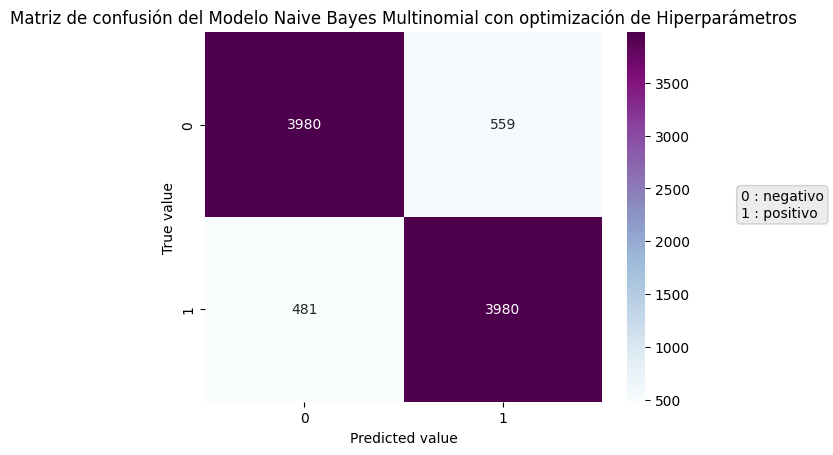

In [36]:
print('F1-Score: {}'.format(f1_score(y_test, y_pred, average='binary')))

confussionMatrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
sns.heatmap(confussionMatrix,cmap='BuPu', annot=True, fmt='g')
plt.xlabel('Predicted value')
plt.ylabel('True value')
plt.title("Matriz de confusión del Modelo Naive Bayes Multinomial con optimización de Hiperparámetros")
plt.text(2.7, 1, f"0 : {labelEncoder.inverse_transform([0])[0]}\n1 : {labelEncoder.inverse_transform([1])[0]}", bbox=dict(boxstyle='round', facecolor='grey', alpha=0.15))
plt.show()

Mostramos las distintas métricas

In [37]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f"Accuracy: {str(accuracy)}")
print(f"Recall: {str(recall)}")
print(f"Precision: {str(precision)}")
print(f"f1 score: {str(f1)}")

Accuracy: 0.8844444444444445
Recall: 0.8921766420085183
Precision: 0.8768451200705001
f1 score: 0.8844444444444444


Realizamos las predicciones de los datos que vamos a submitear a kaggle

In [38]:
y_pred = multinomialNBPipeline.predict(criticsTest["review"])

Agrupamos en el dataframe los valores predichos decodeados con el label encoder

In [39]:
kaggleResult = criticsTest.copy()
kaggleResult.drop(columns=["review"], inplace=True)

kaggleResult["sentimiento"] = labelEncoder.inverse_transform(y_pred)

kaggleResult.head(2)

,ID,sentimiento
0,60000,negativo
1,60001,negativo


Para exportar a Kaggle exportamos el csv. El `runNumber` es sólo un número que ponemos para no pisar los submits

In [40]:
kaggleResult.to_csv(f"submit_{runNumber}_grupo16_gpwin_naive_bayes_multinomial.csv", index=False)

Guardamos una serialización del modelo

In [41]:
filename = f'./naive_bayes_multinomial_model_{runNumber}.joblib'
modelInfo = {'model': multinomialNBPipeline}

joblib.dump(modelInfo, filename)

['./naive_bayes_multinomial_model_4.joblib']

## Random Forest con optimización de hiperparámetros

Similar al Naive Bayes con optimización de hiperparámetros detallado arriba, creamos una pipeline con un CountVectorizer y un TfidfTransformer pero con un predictor que será un clasificador de tipo Random Forest

La optimización de hiperparámetros será de manera bayesiana con la librería optuna. Para el CountVectorizer y el TfidfTransformer se optimizarán los mismos parámetros que con el Naives Bayes, y para el Random Forest se optimizarán los siguientes parámetros:
- n_estimators: cantidad de árboles
- criterion: forma de medir la calidad de un split de un árbol
- min_samples_split: cantidad mínima de muestras requeridas para hacer el split de un nodo
- min_samples_leaf: cantidad mínima de muestras requeridas para estar en un nodo hoja

Creamos la función objetivo que vamos a optimizar

In [29]:
def objective(trial):

    parametersVectorizer = {
        'strip_accents': trial.suggest_categorical('strip_accents', ['ascii', 'unicode', None]),
        'lowercase': trial.suggest_categorical('lowercase', [True, False]),
        'ngram_range': trial.suggest_categorical('ngram_range', [(1,1), (1,2), (2,2)]),
        'binary': trial.suggest_categorical('binary', [True, False]),
        'analyzer': 'word'
    }

    parametersTransformer = {
        'norm': trial.suggest_categorical('norm', ['l1', 'l2', None]),
        'use_idf': trial.suggest_categorical('use_idf', [True, False]),
        'sublinear_tf': trial.suggest_categorical('sublinear_tf', [True, False]),
    }

    parametersModel = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 900, step=5),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
        'min_samples_split' : trial.suggest_int('min_samples_split', 2, 32, step=1),
        'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1, 10, step=1),
        'n_jobs': -1,
        'random_state': 1
    }

    rfPipeline = Pipeline(steps=[
        ('vectorizer', CountVectorizer(**parametersVectorizer)),
        ('tfidfTransformer', TfidfTransformer(**parametersTransformer)),
        ('randomForest', RandomForestClassifier(**parametersModel))
    ])

    rfPipeline.fit(x_train, y_train)
    y_pred = rfPipeline.predict(x_test)

    return f1_score(y_test, y_pred, average='binary')


Creamos un study que va a ser donde corramos el "estudio de maximizar la función objetivo" definida arriba (que optimiza el f1 score)

In [30]:
study = optuna.create_study(direction='maximize')

[I 2023-11-19 09:32:30,330] A new study created in memory with name: no-name-9a904b23-0f1b-434f-bba8-7018368b654f


El método de sampleo de hiperparámetros que seguirá la optimización bayesiana será con el tree-structured Parzen estimators -TPE

In [31]:
study.sampler.__class__.__name__

'TPESampler'

Ejecutamos el estudio

In [32]:
study.optimize(objective, n_trials=100, show_progress_bar=True)

Best trial: 0. Best value: 0.848424:   1%|          | 1/100 [02:50<4:41:59, 170.91s/it]

[I 2023-11-19 09:35:21,248] Trial 0 finished with value: 0.8484238765928906 and parameters: {'strip_accents': None, 'lowercase': False, 'ngram_range': (2, 2), 'binary': True, 'norm': 'l1', 'use_idf': False, 'sublinear_tf': False, 'n_estimators': 385, 'criterion': 'log_loss', 'min_samples_split': 29, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8484238765928906.


Best trial: 0. Best value: 0.848424:   2%|▏         | 2/100 [03:10<2:14:08, 82.12s/it] 

[I 2023-11-19 09:35:41,225] Trial 1 finished with value: 0.8411173184357542 and parameters: {'strip_accents': 'ascii', 'lowercase': True, 'ngram_range': (1, 1), 'binary': False, 'norm': 'l2', 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 120, 'criterion': 'log_loss', 'min_samples_split': 24, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8484238765928906.


Best trial: 2. Best value: 0.855824:   3%|▎         | 3/100 [04:32<2:12:07, 81.72s/it]

[I 2023-11-19 09:37:02,470] Trial 2 finished with value: 0.8558244231851435 and parameters: {'strip_accents': 'unicode', 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'n_estimators': 450, 'criterion': 'log_loss', 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 2 with value: 0.8558244231851435.


Best trial: 2. Best value: 0.855824:   4%|▍         | 4/100 [06:24<2:30:03, 93.78s/it]

[I 2023-11-19 09:38:54,740] Trial 3 finished with value: 0.8437640702386313 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (2, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 740, 'criterion': 'log_loss', 'min_samples_split': 16, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.8558244231851435.


Best trial: 2. Best value: 0.855824:   5%|▌         | 5/100 [06:58<1:54:39, 72.42s/it]

[I 2023-11-19 09:39:29,280] Trial 4 finished with value: 0.8391097331414018 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (2, 2), 'binary': False, 'norm': 'l2', 'use_idf': False, 'sublinear_tf': False, 'n_estimators': 210, 'criterion': 'gini', 'min_samples_split': 19, 'min_samples_leaf': 10}. Best is trial 2 with value: 0.8558244231851435.


Best trial: 2. Best value: 0.855824:   6%|▌         | 6/100 [07:12<1:22:12, 52.48s/it]

[I 2023-11-19 09:39:43,045] Trial 5 finished with value: 0.842745054702177 and parameters: {'strip_accents': 'unicode', 'lowercase': True, 'ngram_range': (1, 1), 'binary': False, 'norm': 'l2', 'use_idf': False, 'sublinear_tf': True, 'n_estimators': 110, 'criterion': 'log_loss', 'min_samples_split': 12, 'min_samples_leaf': 10}. Best is trial 2 with value: 0.8558244231851435.


Best trial: 2. Best value: 0.855824:   7%|▋         | 7/100 [07:32<1:04:50, 41.83s/it]

[I 2023-11-19 09:40:02,956] Trial 6 finished with value: 0.8381956912028725 and parameters: {'strip_accents': 'ascii', 'lowercase': True, 'ngram_range': (1, 1), 'binary': False, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'n_estimators': 325, 'criterion': 'gini', 'min_samples_split': 27, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.8558244231851435.


Best trial: 2. Best value: 0.855824:   8%|▊         | 8/100 [09:10<1:31:36, 59.75s/it]

[I 2023-11-19 09:41:41,068] Trial 7 finished with value: 0.8512730849087532 and parameters: {'strip_accents': 'unicode', 'lowercase': False, 'ngram_range': (2, 2), 'binary': False, 'norm': None, 'use_idf': True, 'sublinear_tf': False, 'n_estimators': 755, 'criterion': 'log_loss', 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 2 with value: 0.8558244231851435.


Best trial: 2. Best value: 0.855824:   9%|▉         | 9/100 [10:03<1:27:08, 57.46s/it]

[I 2023-11-19 09:42:33,500] Trial 8 finished with value: 0.8453495970376823 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (2, 2), 'binary': True, 'norm': None, 'use_idf': False, 'sublinear_tf': False, 'n_estimators': 480, 'criterion': 'entropy', 'min_samples_split': 26, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.8558244231851435.


Best trial: 2. Best value: 0.855824:  10%|█         | 10/100 [16:33<4:00:33, 160.38s/it]

[I 2023-11-19 09:49:04,319] Trial 9 finished with value: 0.8494623655913979 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (2, 2), 'binary': False, 'norm': 'l2', 'use_idf': True, 'sublinear_tf': False, 'n_estimators': 820, 'criterion': 'log_loss', 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.8558244231851435.


Best trial: 10. Best value: 0.859849:  11%|█         | 11/100 [18:49<3:46:37, 152.78s/it]

[I 2023-11-19 09:51:19,884] Trial 10 finished with value: 0.8598489119404668 and parameters: {'strip_accents': 'unicode', 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 515, 'criterion': 'entropy', 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 10 with value: 0.8598489119404668.


Best trial: 11. Best value: 0.861368:  12%|█▏        | 12/100 [21:12<3:39:33, 149.70s/it]

[I 2023-11-19 09:53:42,519] Trial 11 finished with value: 0.8613682546850305 and parameters: {'strip_accents': 'unicode', 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 565, 'criterion': 'entropy', 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 11 with value: 0.8613682546850305.


Best trial: 12. Best value: 0.862617:  13%|█▎        | 13/100 [23:44<3:38:01, 150.36s/it]

[I 2023-11-19 09:56:14,402] Trial 12 finished with value: 0.8626169277583682 and parameters: {'strip_accents': 'unicode', 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 610, 'criterion': 'entropy', 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 12 with value: 0.8626169277583682.


Best trial: 12. Best value: 0.862617:  14%|█▍        | 14/100 [26:16<3:36:20, 150.94s/it]

[I 2023-11-19 09:58:46,683] Trial 13 finished with value: 0.8607195218224879 and parameters: {'strip_accents': 'unicode', 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 620, 'criterion': 'entropy', 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 12 with value: 0.8626169277583682.


Best trial: 14. Best value: 0.863231:  15%|█▌        | 15/100 [28:40<3:31:07, 149.03s/it]

[I 2023-11-19 10:01:11,293] Trial 14 finished with value: 0.8632314804374789 and parameters: {'strip_accents': 'unicode', 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 620, 'criterion': 'entropy', 'min_samples_split': 16, 'min_samples_leaf': 4}. Best is trial 14 with value: 0.8632314804374789.


Best trial: 15. Best value: 0.863933:  16%|█▌        | 16/100 [31:06<3:27:12, 148.00s/it]

[I 2023-11-19 10:03:36,908] Trial 15 finished with value: 0.8639333183149358 and parameters: {'strip_accents': 'unicode', 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 630, 'criterion': 'entropy', 'min_samples_split': 16, 'min_samples_leaf': 4}. Best is trial 15 with value: 0.8639333183149358.


Best trial: 16. Best value: 0.864411:  17%|█▋        | 17/100 [49:22<9:58:55, 432.96s/it]

[I 2023-11-19 10:21:52,550] Trial 16 finished with value: 0.8644105286441053 and parameters: {'strip_accents': 'unicode', 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 900, 'criterion': 'entropy', 'min_samples_split': 20, 'min_samples_leaf': 1}. Best is trial 16 with value: 0.8644105286441053.


Best trial: 16. Best value: 0.864411:  18%|█▊        | 18/100 [1:07:19<14:16:13, 626.50s/it]

[I 2023-11-19 10:39:49,600] Trial 17 finished with value: 0.8618282548476455 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 895, 'criterion': 'entropy', 'min_samples_split': 21, 'min_samples_leaf': 1}. Best is trial 16 with value: 0.8644105286441053.


Best trial: 16. Best value: 0.864411:  19%|█▉        | 19/100 [1:24:57<17:00:59, 756.29s/it]

[I 2023-11-19 10:57:28,236] Trial 18 finished with value: 0.8633952254641909 and parameters: {'strip_accents': 'unicode', 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': False, 'sublinear_tf': True, 'n_estimators': 895, 'criterion': 'entropy', 'min_samples_split': 22, 'min_samples_leaf': 1}. Best is trial 16 with value: 0.8644105286441053.


Best trial: 19. Best value: 0.866468:  20%|██        | 20/100 [1:27:59<12:58:13, 583.66s/it]

[I 2023-11-19 11:00:29,569] Trial 19 finished with value: 0.8664675295939815 and parameters: {'strip_accents': 'unicode', 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 710, 'criterion': 'gini', 'min_samples_split': 14, 'min_samples_leaf': 3}. Best is trial 19 with value: 0.8664675295939815.


Best trial: 19. Best value: 0.866468:  21%|██        | 21/100 [1:30:50<10:05:25, 459.81s/it]

[I 2023-11-19 11:03:20,632] Trial 20 finished with value: 0.8661295662730383 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 750, 'criterion': 'gini', 'min_samples_split': 31, 'min_samples_leaf': 3}. Best is trial 19 with value: 0.8664675295939815.


Best trial: 19. Best value: 0.866468:  22%|██▏       | 22/100 [1:33:35<8:02:46, 371.37s/it] 

[I 2023-11-19 11:06:05,746] Trial 21 finished with value: 0.8661000110387459 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 720, 'criterion': 'gini', 'min_samples_split': 31, 'min_samples_leaf': 3}. Best is trial 19 with value: 0.8664675295939815.


Best trial: 19. Best value: 0.866468:  23%|██▎       | 23/100 [1:36:22<6:38:01, 310.15s/it]

[I 2023-11-19 11:08:53,103] Trial 22 finished with value: 0.8655035335689046 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 735, 'criterion': 'gini', 'min_samples_split': 32, 'min_samples_leaf': 3}. Best is trial 19 with value: 0.8664675295939815.


Best trial: 19. Best value: 0.866468:  24%|██▍       | 24/100 [1:39:05<5:36:50, 265.93s/it]

[I 2023-11-19 11:11:35,890] Trial 23 finished with value: 0.8661956281739899 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 710, 'criterion': 'gini', 'min_samples_split': 31, 'min_samples_leaf': 3}. Best is trial 19 with value: 0.8664675295939815.


Best trial: 19. Best value: 0.866468:  25%|██▌       | 25/100 [1:41:04<4:37:14, 221.80s/it]

[I 2023-11-19 11:13:34,728] Trial 24 finished with value: 0.8641430305705773 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 805, 'criterion': 'gini', 'min_samples_split': 29, 'min_samples_leaf': 5}. Best is trial 19 with value: 0.8664675295939815.


Best trial: 19. Best value: 0.866468:  26%|██▌       | 26/100 [1:41:55<3:30:34, 170.73s/it]

[I 2023-11-19 11:14:26,328] Trial 25 finished with value: 0.8553040390590324 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (1, 1), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 675, 'criterion': 'gini', 'min_samples_split': 14, 'min_samples_leaf': 3}. Best is trial 19 with value: 0.8664675295939815.


Best trial: 19. Best value: 0.866468:  27%|██▋       | 27/100 [1:47:13<4:21:25, 214.88s/it]

[I 2023-11-19 11:19:44,192] Trial 26 finished with value: 0.8641322314049588 and parameters: {'strip_accents': None, 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': False, 'sublinear_tf': True, 'n_estimators': 815, 'criterion': 'gini', 'min_samples_split': 23, 'min_samples_leaf': 2}. Best is trial 19 with value: 0.8664675295939815.


Best trial: 19. Best value: 0.866468:  28%|██▊       | 28/100 [1:48:41<3:32:03, 176.71s/it]

[I 2023-11-19 11:21:11,854] Trial 27 finished with value: 0.8628142920158801 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 535, 'criterion': 'gini', 'min_samples_split': 29, 'min_samples_leaf': 5}. Best is trial 19 with value: 0.8664675295939815.


Best trial: 19. Best value: 0.866468:  29%|██▉       | 29/100 [1:51:24<3:24:06, 172.48s/it]

[I 2023-11-19 11:23:54,480] Trial 28 finished with value: 0.8627580876669979 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 695, 'criterion': 'gini', 'min_samples_split': 26, 'min_samples_leaf': 3}. Best is trial 19 with value: 0.8664675295939815.


Best trial: 19. Best value: 0.866468:  30%|███       | 30/100 [1:52:02<2:34:24, 132.35s/it]

[I 2023-11-19 11:24:33,193] Trial 29 finished with value: 0.8495378104465976 and parameters: {'strip_accents': None, 'lowercase': False, 'ngram_range': (1, 1), 'binary': True, 'norm': None, 'use_idf': False, 'sublinear_tf': True, 'n_estimators': 310, 'criterion': 'gini', 'min_samples_split': 18, 'min_samples_leaf': 2}. Best is trial 19 with value: 0.8664675295939815.


Best trial: 19. Best value: 0.866468:  31%|███       | 31/100 [1:53:17<2:12:14, 115.00s/it]

[I 2023-11-19 11:25:47,692] Trial 30 finished with value: 0.8607119168693345 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 420, 'criterion': 'gini', 'min_samples_split': 31, 'min_samples_leaf': 5}. Best is trial 19 with value: 0.8664675295939815.


Best trial: 31. Best value: 0.866762:  32%|███▏      | 32/100 [1:55:53<2:24:18, 127.33s/it]

[I 2023-11-19 11:28:23,796] Trial 31 finished with value: 0.8667623357986532 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 675, 'criterion': 'gini', 'min_samples_split': 31, 'min_samples_leaf': 3}. Best is trial 31 with value: 0.8667623357986532.


Best trial: 31. Best value: 0.866762:  33%|███▎      | 33/100 [1:58:30<2:32:15, 136.35s/it]

[I 2023-11-19 11:31:01,208] Trial 32 finished with value: 0.8622516556291391 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 675, 'criterion': 'gini', 'min_samples_split': 29, 'min_samples_leaf': 3}. Best is trial 31 with value: 0.8667623357986532.


Best trial: 31. Best value: 0.866762:  34%|███▍      | 34/100 [2:03:21<3:20:57, 182.68s/it]

[I 2023-11-19 11:35:51,998] Trial 33 finished with value: 0.8655564133671555 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 785, 'criterion': 'gini', 'min_samples_split': 27, 'min_samples_leaf': 2}. Best is trial 31 with value: 0.8667623357986532.


Best trial: 31. Best value: 0.866762:  35%|███▌      | 35/100 [2:05:38<3:03:09, 169.06s/it]

[I 2023-11-19 11:38:09,283] Trial 34 finished with value: 0.8642084345330096 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 580, 'criterion': 'gini', 'min_samples_split': 32, 'min_samples_leaf': 3}. Best is trial 31 with value: 0.8667623357986532.


Best trial: 31. Best value: 0.866762:  36%|███▌      | 36/100 [2:16:17<5:30:29, 309.84s/it]

[I 2023-11-19 11:48:47,606] Trial 35 finished with value: 0.8580865603644646 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (1, 2), 'binary': False, 'norm': 'l2', 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 660, 'criterion': 'gini', 'min_samples_split': 25, 'min_samples_leaf': 1}. Best is trial 31 with value: 0.8667623357986532.


Best trial: 31. Best value: 0.866762:  37%|███▋      | 37/100 [2:16:48<3:57:42, 226.38s/it]

[I 2023-11-19 11:49:19,244] Trial 36 finished with value: 0.8512570605825672 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (1, 1), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': False, 'n_estimators': 765, 'criterion': 'gini', 'min_samples_split': 13, 'min_samples_leaf': 7}. Best is trial 31 with value: 0.8667623357986532.


Best trial: 31. Best value: 0.866762:  38%|███▊      | 38/100 [2:18:31<3:15:42, 189.40s/it]

[I 2023-11-19 11:51:02,342] Trial 37 finished with value: 0.846812771164757 and parameters: {'strip_accents': 'ascii', 'lowercase': True, 'ngram_range': (2, 2), 'binary': False, 'norm': 'l2', 'use_idf': False, 'sublinear_tf': True, 'n_estimators': 835, 'criterion': 'gini', 'min_samples_split': 24, 'min_samples_leaf': 6}. Best is trial 31 with value: 0.8667623357986532.


Best trial: 31. Best value: 0.866762:  39%|███▉      | 39/100 [2:23:56<3:53:51, 230.03s/it]

[I 2023-11-19 11:56:27,191] Trial 38 finished with value: 0.8634604754007739 and parameters: {'strip_accents': None, 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': False, 'n_estimators': 855, 'criterion': 'gini', 'min_samples_split': 30, 'min_samples_leaf': 2}. Best is trial 31 with value: 0.8667623357986532.


Best trial: 31. Best value: 0.866762:  40%|████      | 40/100 [2:24:25<2:49:37, 169.62s/it]

[I 2023-11-19 11:56:55,865] Trial 39 finished with value: 0.8496615999112394 and parameters: {'strip_accents': 'ascii', 'lowercase': True, 'ngram_range': (1, 1), 'binary': False, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 725, 'criterion': 'log_loss', 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 31 with value: 0.8667623357986532.


Best trial: 31. Best value: 0.866762:  41%|████      | 41/100 [2:25:07<2:09:09, 131.34s/it]

[I 2023-11-19 11:57:37,890] Trial 40 finished with value: 0.8414057220094615 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (2, 2), 'binary': True, 'norm': 'l2', 'use_idf': False, 'sublinear_tf': False, 'n_estimators': 190, 'criterion': 'gini', 'min_samples_split': 27, 'min_samples_leaf': 5}. Best is trial 31 with value: 0.8667623357986532.


Best trial: 31. Best value: 0.866762:  42%|████▏     | 42/100 [2:27:54<2:17:18, 142.05s/it]

[I 2023-11-19 12:00:24,921] Trial 41 finished with value: 0.8642793987621575 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 730, 'criterion': 'gini', 'min_samples_split': 30, 'min_samples_leaf': 3}. Best is trial 31 with value: 0.8667623357986532.


Best trial: 31. Best value: 0.866762:  43%|████▎     | 43/100 [2:28:31<1:45:02, 110.56s/it]

[I 2023-11-19 12:01:02,013] Trial 42 finished with value: 0.8397521027003099 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 60, 'criterion': 'gini', 'min_samples_split': 32, 'min_samples_leaf': 3}. Best is trial 31 with value: 0.8667623357986532.


Best trial: 31. Best value: 0.866762:  44%|████▍     | 44/100 [2:32:52<2:25:11, 155.55s/it]

[I 2023-11-19 12:05:22,552] Trial 43 finished with value: 0.8642983230361871 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 700, 'criterion': 'gini', 'min_samples_split': 28, 'min_samples_leaf': 2}. Best is trial 31 with value: 0.8667623357986532.


Best trial: 31. Best value: 0.866762:  45%|████▌     | 45/100 [2:35:17<2:19:45, 152.46s/it]

[I 2023-11-19 12:07:47,793] Trial 44 finished with value: 0.8625027587728978 and parameters: {'strip_accents': None, 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 770, 'criterion': 'log_loss', 'min_samples_split': 31, 'min_samples_leaf': 4}. Best is trial 31 with value: 0.8667623357986532.


Best trial: 31. Best value: 0.866762:  46%|████▌     | 46/100 [2:38:24<2:26:26, 162.71s/it]

[I 2023-11-19 12:10:54,409] Trial 45 finished with value: 0.8638674033149172 and parameters: {'strip_accents': 'ascii', 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 650, 'criterion': 'gini', 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 31 with value: 0.8667623357986532.


Best trial: 31. Best value: 0.866762:  47%|████▋     | 47/100 [2:40:14<2:09:58, 147.14s/it]

[I 2023-11-19 12:12:45,225] Trial 46 finished with value: 0.853177662738187 and parameters: {'strip_accents': 'unicode', 'lowercase': True, 'ngram_range': (2, 2), 'binary': False, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 590, 'criterion': 'gini', 'min_samples_split': 11, 'min_samples_leaf': 4}. Best is trial 31 with value: 0.8667623357986532.


Best trial: 31. Best value: 0.866762:  48%|████▊     | 48/100 [2:43:24<2:18:40, 160.00s/it]

[I 2023-11-19 12:15:55,234] Trial 47 finished with value: 0.8637617209045781 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': False, 'n_estimators': 490, 'criterion': 'gini', 'min_samples_split': 30, 'min_samples_leaf': 2}. Best is trial 31 with value: 0.8667623357986532.


Best trial: 31. Best value: 0.866762:  49%|████▉     | 49/100 [2:45:36<2:08:39, 151.37s/it]

[I 2023-11-19 12:18:06,461] Trial 48 finished with value: 0.8598531902879729 and parameters: {'strip_accents': 'unicode', 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l2', 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 540, 'criterion': 'log_loss', 'min_samples_split': 15, 'min_samples_leaf': 4}. Best is trial 31 with value: 0.8667623357986532.


Best trial: 31. Best value: 0.866762:  50%|█████     | 50/100 [2:48:28<2:11:21, 157.62s/it]

[I 2023-11-19 12:20:58,663] Trial 49 finished with value: 0.8639131879083158 and parameters: {'strip_accents': None, 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 715, 'criterion': 'gini', 'min_samples_split': 28, 'min_samples_leaf': 3}. Best is trial 31 with value: 0.8667623357986532.


Best trial: 31. Best value: 0.866762:  51%|█████     | 51/100 [2:55:54<3:19:30, 244.30s/it]

[I 2023-11-19 12:28:25,224] Trial 50 finished with value: 0.8578078244486314 and parameters: {'strip_accents': 'unicode', 'lowercase': True, 'ngram_range': (1, 2), 'binary': False, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 360, 'criterion': 'gini', 'min_samples_split': 19, 'min_samples_leaf': 1}. Best is trial 31 with value: 0.8667623357986532.


Best trial: 31. Best value: 0.866762:  52%|█████▏    | 52/100 [3:00:46<3:26:46, 258.47s/it]

[I 2023-11-19 12:33:16,769] Trial 51 finished with value: 0.8655564133671555 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 785, 'criterion': 'gini', 'min_samples_split': 27, 'min_samples_leaf': 2}. Best is trial 31 with value: 0.8667623357986532.


Best trial: 31. Best value: 0.866762:  53%|█████▎    | 53/100 [3:05:55<3:34:22, 273.67s/it]

[I 2023-11-19 12:38:25,913] Trial 52 finished with value: 0.8636413823561886 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 845, 'criterion': 'gini', 'min_samples_split': 31, 'min_samples_leaf': 2}. Best is trial 31 with value: 0.8667623357986532.


Best trial: 31. Best value: 0.866762:  54%|█████▍    | 54/100 [3:10:48<3:34:09, 279.35s/it]

[I 2023-11-19 12:43:18,489] Trial 53 finished with value: 0.8667255075022064 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 790, 'criterion': 'gini', 'min_samples_split': 28, 'min_samples_leaf': 2}. Best is trial 31 with value: 0.8667623357986532.


Best trial: 31. Best value: 0.866762:  55%|█████▌    | 55/100 [3:13:54<3:08:31, 251.37s/it]

[I 2023-11-19 12:46:24,571] Trial 54 finished with value: 0.8610047307952242 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 740, 'criterion': 'gini', 'min_samples_split': 32, 'min_samples_leaf': 3}. Best is trial 31 with value: 0.8667623357986532.


Best trial: 31. Best value: 0.866762:  56%|█████▌    | 56/100 [3:28:40<5:23:54, 441.69s/it]

[I 2023-11-19 13:01:10,360] Trial 55 finished with value: 0.863495575221239 and parameters: {'strip_accents': 'ascii', 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 860, 'criterion': 'gini', 'min_samples_split': 30, 'min_samples_leaf': 1}. Best is trial 31 with value: 0.8667623357986532.


Best trial: 31. Best value: 0.866762:  57%|█████▋    | 57/100 [3:30:38<4:07:06, 344.80s/it]

[I 2023-11-19 13:03:09,064] Trial 56 finished with value: 0.8637917723613102 and parameters: {'strip_accents': 'unicode', 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': False, 'sublinear_tf': True, 'n_estimators': 635, 'criterion': 'gini', 'min_samples_split': 28, 'min_samples_leaf': 4}. Best is trial 31 with value: 0.8667623357986532.


Best trial: 31. Best value: 0.866762:  58%|█████▊    | 58/100 [3:33:11<3:21:08, 287.34s/it]

[I 2023-11-19 13:05:42,330] Trial 57 finished with value: 0.8554057041786426 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (2, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 685, 'criterion': 'log_loss', 'min_samples_split': 26, 'min_samples_leaf': 3}. Best is trial 31 with value: 0.8667623357986532.


Best trial: 31. Best value: 0.866762:  59%|█████▉    | 59/100 [3:34:35<2:34:37, 226.28s/it]

[I 2023-11-19 13:07:06,150] Trial 58 finished with value: 0.8459995542678851 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (1, 1), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'n_estimators': 800, 'criterion': 'gini', 'min_samples_split': 31, 'min_samples_leaf': 2}. Best is trial 31 with value: 0.8667623357986532.


Best trial: 31. Best value: 0.866762:  60%|██████    | 60/100 [3:36:54<2:13:19, 199.98s/it]

[I 2023-11-19 13:09:24,760] Trial 59 finished with value: 0.8636363636363635 and parameters: {'strip_accents': 'unicode', 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 755, 'criterion': 'gini', 'min_samples_split': 25, 'min_samples_leaf': 4}. Best is trial 31 with value: 0.8667623357986532.


Best trial: 31. Best value: 0.866762:  61%|██████    | 61/100 [3:38:07<1:45:13, 161.89s/it]

[I 2023-11-19 13:10:37,765] Trial 60 finished with value: 0.853819139596137 and parameters: {'strip_accents': None, 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 600, 'criterion': 'gini', 'min_samples_split': 17, 'min_samples_leaf': 10}. Best is trial 31 with value: 0.8667623357986532.


Best trial: 31. Best value: 0.866762:  62%|██████▏   | 62/100 [3:42:58<2:07:07, 200.73s/it]

[I 2023-11-19 13:15:29,120] Trial 61 finished with value: 0.8667255075022064 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 790, 'criterion': 'gini', 'min_samples_split': 28, 'min_samples_leaf': 2}. Best is trial 31 with value: 0.8667623357986532.


Best trial: 31. Best value: 0.866762:  63%|██████▎   | 63/100 [3:46:15<2:03:01, 199.51s/it]

[I 2023-11-19 13:18:45,796] Trial 62 finished with value: 0.8647039364869334 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 875, 'criterion': 'gini', 'min_samples_split': 29, 'min_samples_leaf': 3}. Best is trial 31 with value: 0.8667623357986532.


Best trial: 31. Best value: 0.866762:  64%|██████▍   | 64/100 [3:59:32<3:47:13, 378.72s/it]

[I 2023-11-19 13:32:02,667] Trial 63 finished with value: 0.8599801390268124 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 755, 'criterion': 'gini', 'min_samples_split': 29, 'min_samples_leaf': 1}. Best is trial 31 with value: 0.8667623357986532.


Best trial: 64. Best value: 0.867116:  65%|██████▌   | 65/100 [4:02:35<3:06:38, 319.95s/it]

[I 2023-11-19 13:35:05,485] Trial 64 finished with value: 0.8671158731912073 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 815, 'criterion': 'gini', 'min_samples_split': 32, 'min_samples_leaf': 3}. Best is trial 64 with value: 0.8671158731912073.


Best trial: 65. Best value: 0.867662:  66%|██████▌   | 66/100 [4:07:50<3:00:27, 318.45s/it]

[I 2023-11-19 13:40:20,420] Trial 65 finished with value: 0.8676616915422886 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 810, 'criterion': 'entropy', 'min_samples_split': 32, 'min_samples_leaf': 2}. Best is trial 65 with value: 0.8676616915422886.


Best trial: 65. Best value: 0.867662:  67%|██████▋   | 67/100 [4:13:12<2:55:44, 319.52s/it]

[I 2023-11-19 13:45:42,447] Trial 66 finished with value: 0.8672194582642344 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 830, 'criterion': 'entropy', 'min_samples_split': 32, 'min_samples_leaf': 2}. Best is trial 65 with value: 0.8676616915422886.


Best trial: 65. Best value: 0.867662:  68%|██████▊   | 68/100 [4:27:37<4:17:44, 483.27s/it]

[I 2023-11-19 14:00:07,816] Trial 67 finished with value: 0.8625718073353956 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 825, 'criterion': 'entropy', 'min_samples_split': 32, 'min_samples_leaf': 1}. Best is trial 65 with value: 0.8676616915422886.


Best trial: 65. Best value: 0.867662:  69%|██████▉   | 69/100 [4:34:00<3:54:06, 453.13s/it]

[I 2023-11-19 14:06:30,605] Trial 68 finished with value: 0.8635501506192123 and parameters: {'strip_accents': 'unicode', 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l2', 'use_idf': False, 'sublinear_tf': True, 'n_estimators': 875, 'criterion': 'entropy', 'min_samples_split': 14, 'min_samples_leaf': 2}. Best is trial 65 with value: 0.8676616915422886.


Best trial: 65. Best value: 0.867662:  70%|███████   | 70/100 [4:39:42<3:29:54, 419.83s/it]

[I 2023-11-19 14:12:12,732] Trial 69 finished with value: 0.8623090745732256 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 825, 'criterion': 'entropy', 'min_samples_split': 28, 'min_samples_leaf': 2}. Best is trial 65 with value: 0.8676616915422886.


Best trial: 65. Best value: 0.867662:  71%|███████   | 71/100 [4:55:27<4:39:01, 577.29s/it]

[I 2023-11-19 14:27:57,436] Trial 70 finished with value: 0.8619506254843351 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (1, 2), 'binary': False, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 810, 'criterion': 'entropy', 'min_samples_split': 22, 'min_samples_leaf': 1}. Best is trial 65 with value: 0.8676616915422886.


Best trial: 71. Best value: 0.867824:  72%|███████▏  | 72/100 [5:00:41<3:52:37, 498.48s/it]

[I 2023-11-19 14:33:12,027] Trial 71 finished with value: 0.8678243557128636 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 805, 'criterion': 'entropy', 'min_samples_split': 30, 'min_samples_leaf': 2}. Best is trial 71 with value: 0.8678243557128636.


Best trial: 71. Best value: 0.867824:  73%|███████▎  | 73/100 [5:05:48<3:18:23, 440.88s/it]

[I 2023-11-19 14:38:18,510] Trial 72 finished with value: 0.8677283786772839 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 790, 'criterion': 'entropy', 'min_samples_split': 30, 'min_samples_leaf': 2}. Best is trial 71 with value: 0.8678243557128636.


Best trial: 71. Best value: 0.867824:  74%|███████▍  | 74/100 [5:10:52<2:53:13, 399.77s/it]

[I 2023-11-19 14:43:22,350] Trial 73 finished with value: 0.8676031412454375 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 785, 'criterion': 'entropy', 'min_samples_split': 30, 'min_samples_leaf': 2}. Best is trial 71 with value: 0.8678243557128636.


Best trial: 74. Best value: 0.86787:  75%|███████▌  | 75/100 [5:16:27<2:38:32, 380.50s/it] 

[I 2023-11-19 14:48:57,895] Trial 74 finished with value: 0.8678701960349984 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 875, 'criterion': 'entropy', 'min_samples_split': 30, 'min_samples_leaf': 2}. Best is trial 74 with value: 0.8678701960349984.


Best trial: 74. Best value: 0.86787:  76%|███████▌  | 76/100 [5:31:33<3:35:13, 538.07s/it]

[I 2023-11-19 15:04:03,612] Trial 75 finished with value: 0.8624806544328986 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 880, 'criterion': 'entropy', 'min_samples_split': 32, 'min_samples_leaf': 1}. Best is trial 74 with value: 0.8678701960349984.


Best trial: 74. Best value: 0.86787:  77%|███████▋  | 77/100 [5:32:56<2:33:54, 401.50s/it]

[I 2023-11-19 15:05:26,454] Trial 76 finished with value: 0.8563806136060471 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (1, 1), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 845, 'criterion': 'entropy', 'min_samples_split': 30, 'min_samples_leaf': 2}. Best is trial 74 with value: 0.8678701960349984.


Best trial: 74. Best value: 0.86787:  78%|███████▊  | 78/100 [5:48:37<3:26:34, 563.40s/it]

[I 2023-11-19 15:21:07,621] Trial 77 finished with value: 0.8625498007968128 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': False, 'n_estimators': 895, 'criterion': 'entropy', 'min_samples_split': 30, 'min_samples_leaf': 1}. Best is trial 74 with value: 0.8678701960349984.


Best trial: 74. Best value: 0.86787:  79%|███████▉  | 79/100 [5:53:54<2:51:22, 489.65s/it]

[I 2023-11-19 15:26:25,208] Trial 78 finished with value: 0.8579907672015826 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (2, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 860, 'criterion': 'entropy', 'min_samples_split': 32, 'min_samples_leaf': 2}. Best is trial 74 with value: 0.8678701960349984.


Best trial: 74. Best value: 0.86787:  80%|████████  | 80/100 [5:59:05<2:25:17, 435.89s/it]

[I 2023-11-19 15:31:35,649] Trial 79 finished with value: 0.8662166648223968 and parameters: {'strip_accents': None, 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 770, 'criterion': 'entropy', 'min_samples_split': 31, 'min_samples_leaf': 2}. Best is trial 74 with value: 0.8678701960349984.


Best trial: 74. Best value: 0.86787:  81%|████████  | 81/100 [6:00:31<1:44:50, 331.08s/it]

[I 2023-11-19 15:33:02,164] Trial 80 finished with value: 0.859881031064111 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': False, 'sublinear_tf': True, 'n_estimators': 825, 'criterion': 'entropy', 'min_samples_split': 29, 'min_samples_leaf': 9}. Best is trial 74 with value: 0.8678701960349984.


Best trial: 74. Best value: 0.86787:  82%|████████▏ | 82/100 [6:05:33<1:36:41, 322.30s/it]

[I 2023-11-19 15:38:03,991] Trial 81 finished with value: 0.8674485505642842 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 780, 'criterion': 'entropy', 'min_samples_split': 30, 'min_samples_leaf': 2}. Best is trial 74 with value: 0.8678701960349984.


Best trial: 74. Best value: 0.86787:  83%|████████▎ | 83/100 [6:19:38<2:15:46, 479.22s/it]

[I 2023-11-19 15:52:09,336] Trial 82 finished with value: 0.8629014396456256 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 810, 'criterion': 'entropy', 'min_samples_split': 31, 'min_samples_leaf': 1}. Best is trial 74 with value: 0.8678701960349984.


Best trial: 74. Best value: 0.86787:  84%|████████▍ | 84/100 [6:24:39<1:53:31, 425.72s/it]

[I 2023-11-19 15:57:10,228] Trial 83 finished with value: 0.8672566371681416 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 775, 'criterion': 'entropy', 'min_samples_split': 30, 'min_samples_leaf': 2}. Best is trial 74 with value: 0.8678701960349984.


Best trial: 74. Best value: 0.86787:  85%|████████▌ | 85/100 [6:29:40<1:37:04, 388.27s/it]

[I 2023-11-19 16:02:11,123] Trial 84 finished with value: 0.8672566371681416 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 775, 'criterion': 'entropy', 'min_samples_split': 30, 'min_samples_leaf': 2}. Best is trial 74 with value: 0.8678701960349984.


Best trial: 74. Best value: 0.86787:  86%|████████▌ | 86/100 [6:34:43<1:24:35, 362.52s/it]

[I 2023-11-19 16:07:13,549] Trial 85 finished with value: 0.8678243557128636 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 775, 'criterion': 'entropy', 'min_samples_split': 27, 'min_samples_leaf': 2}. Best is trial 74 with value: 0.8678701960349984.


Best trial: 86. Best value: 0.871296:  87%|████████▋ | 87/100 [6:39:44<1:14:32, 344.01s/it]

[I 2023-11-19 16:12:14,389] Trial 86 finished with value: 0.8712958867757629 and parameters: {'strip_accents': 'ascii', 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 775, 'criterion': 'entropy', 'min_samples_split': 27, 'min_samples_leaf': 2}. Best is trial 86 with value: 0.8712958867757629.


Best trial: 86. Best value: 0.871296:  88%|████████▊ | 88/100 [6:51:32<1:30:38, 453.20s/it]

[I 2023-11-19 16:24:02,352] Trial 87 finished with value: 0.8593130030608774 and parameters: {'strip_accents': 'ascii', 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l2', 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 745, 'criterion': 'entropy', 'min_samples_split': 25, 'min_samples_leaf': 1}. Best is trial 86 with value: 0.8712958867757629.


Best trial: 86. Best value: 0.871296:  89%|████████▉ | 89/100 [6:56:42<1:15:15, 410.51s/it]

[I 2023-11-19 16:29:13,243] Trial 88 finished with value: 0.8709962447537 and parameters: {'strip_accents': 'ascii', 'lowercase': True, 'ngram_range': (1, 2), 'binary': False, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 795, 'criterion': 'entropy', 'min_samples_split': 26, 'min_samples_leaf': 2}. Best is trial 86 with value: 0.8712958867757629.


Best trial: 86. Best value: 0.871296:  90%|█████████ | 90/100 [6:58:11<52:20, 314.03s/it]  

[I 2023-11-19 16:30:42,160] Trial 89 finished with value: 0.8562541657409465 and parameters: {'strip_accents': 'ascii', 'lowercase': True, 'ngram_range': (1, 1), 'binary': False, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 860, 'criterion': 'entropy', 'min_samples_split': 24, 'min_samples_leaf': 2}. Best is trial 86 with value: 0.8712958867757629.


Best trial: 86. Best value: 0.871296:  91%|█████████ | 91/100 [7:03:06<46:13, 308.14s/it]

[I 2023-11-19 16:35:36,569] Trial 90 finished with value: 0.8616041339024939 and parameters: {'strip_accents': 'ascii', 'lowercase': True, 'ngram_range': (1, 2), 'binary': False, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'n_estimators': 725, 'criterion': 'entropy', 'min_samples_split': 27, 'min_samples_leaf': 2}. Best is trial 86 with value: 0.8712958867757629.


Best trial: 86. Best value: 0.871296:  92%|█████████▏| 92/100 [7:08:16<41:10, 308.81s/it]

[I 2023-11-19 16:40:46,942] Trial 91 finished with value: 0.8709962447537 and parameters: {'strip_accents': 'ascii', 'lowercase': True, 'ngram_range': (1, 2), 'binary': False, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 795, 'criterion': 'entropy', 'min_samples_split': 26, 'min_samples_leaf': 2}. Best is trial 86 with value: 0.8712958867757629.


Best trial: 86. Best value: 0.871296:  93%|█████████▎| 93/100 [7:22:45<55:38, 476.98s/it]

[I 2023-11-19 16:55:16,307] Trial 92 finished with value: 0.8628925254312253 and parameters: {'strip_accents': 'ascii', 'lowercase': True, 'ngram_range': (1, 2), 'binary': False, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 800, 'criterion': 'entropy', 'min_samples_split': 26, 'min_samples_leaf': 1}. Best is trial 86 with value: 0.8712958867757629.


Best trial: 86. Best value: 0.871296:  94%|█████████▍| 94/100 [7:24:50<37:06, 371.14s/it]

[I 2023-11-19 16:57:20,490] Trial 93 finished with value: 0.8669024983418087 and parameters: {'strip_accents': 'ascii', 'lowercase': True, 'ngram_range': (1, 2), 'binary': False, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 275, 'criterion': 'entropy', 'min_samples_split': 27, 'min_samples_leaf': 2}. Best is trial 86 with value: 0.8712958867757629.


Best trial: 86. Best value: 0.871296:  95%|█████████▌| 95/100 [7:30:21<29:55, 359.15s/it]

[I 2023-11-19 17:02:51,672] Trial 94 finished with value: 0.8702660925251187 and parameters: {'strip_accents': 'ascii', 'lowercase': True, 'ngram_range': (1, 2), 'binary': False, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 845, 'criterion': 'entropy', 'min_samples_split': 24, 'min_samples_leaf': 2}. Best is trial 86 with value: 0.8712958867757629.


Best trial: 86. Best value: 0.871296:  96%|█████████▌| 96/100 [7:33:44<20:49, 312.34s/it]

[I 2023-11-19 17:06:14,782] Trial 95 finished with value: 0.8702391496899912 and parameters: {'strip_accents': 'ascii', 'lowercase': True, 'ngram_range': (1, 2), 'binary': False, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 845, 'criterion': 'entropy', 'min_samples_split': 24, 'min_samples_leaf': 3}. Best is trial 86 with value: 0.8712958867757629.


Best trial: 96. Best value: 0.872703:  97%|█████████▋| 97/100 [7:37:07<13:58, 279.56s/it]

[I 2023-11-19 17:09:37,841] Trial 96 finished with value: 0.8727031215408457 and parameters: {'strip_accents': 'ascii', 'lowercase': True, 'ngram_range': (1, 2), 'binary': False, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 840, 'criterion': 'entropy', 'min_samples_split': 23, 'min_samples_leaf': 3}. Best is trial 96 with value: 0.8727031215408457.


Best trial: 96. Best value: 0.872703:  98%|█████████▊| 98/100 [7:40:36<08:36, 258.47s/it]

[I 2023-11-19 17:13:07,107] Trial 97 finished with value: 0.8531422271223815 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (2, 2), 'binary': False, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'n_estimators': 895, 'criterion': 'entropy', 'min_samples_split': 23, 'min_samples_leaf': 3}. Best is trial 96 with value: 0.8727031215408457.


Best trial: 96. Best value: 0.872703:  99%|█████████▉| 99/100 [7:43:58<04:01, 241.53s/it]

[I 2023-11-19 17:16:29,118] Trial 98 finished with value: 0.8702391496899912 and parameters: {'strip_accents': 'ascii', 'lowercase': True, 'ngram_range': (1, 2), 'binary': False, 'norm': None, 'use_idf': False, 'sublinear_tf': True, 'n_estimators': 845, 'criterion': 'entropy', 'min_samples_split': 24, 'min_samples_leaf': 3}. Best is trial 96 with value: 0.8727031215408457.


Best trial: 96. Best value: 0.872703: 100%|██████████| 100/100 [7:47:21<00:00, 280.41s/it]

[I 2023-11-19 17:19:51,559] Trial 99 finished with value: 0.870421600088525 and parameters: {'strip_accents': 'ascii', 'lowercase': True, 'ngram_range': (1, 2), 'binary': False, 'norm': None, 'use_idf': False, 'sublinear_tf': True, 'n_estimators': 850, 'criterion': 'entropy', 'min_samples_split': 24, 'min_samples_leaf': 3}. Best is trial 96 with value: 0.8727031215408457.


Las 100 iteraciones del estudio tardaron 7.7 horas en total

Seleccionamos el mejor trial (intento) con el mejor score y el mejor conjunto de hiperparámetros

In [33]:
bestTrial = study.best_trial
bestScore = bestTrial.value
hyperparameters = bestTrial.params

print('Cantidad de trials total: {}'.format(len(study.trials)))
print('Mejor f1score: ' + str(bestScore) + "\n")

for param, value in hyperparameters.items():
    print(f"{param}: {value}")

Cantidad de trials total: 100
Mejor f1score: 0.8727031215408457

strip_accents: ascii
lowercase: True
ngram_range: (1, 2)
binary: False
norm: None
use_idf: True
sublinear_tf: True
n_estimators: 840
criterion: entropy
min_samples_split: 23
min_samples_leaf: 3


Recreamos una pipeline con estos mejores parámetros

In [34]:
runNumber = 3

parametersVectorizer = {
    'strip_accents': hyperparameters["strip_accents"],
    'lowercase': hyperparameters["lowercase"],
    'ngram_range': hyperparameters["ngram_range"],
    'binary': hyperparameters["binary"],
    'analyzer': 'word'
}

parametersTransformer = {
    'norm': hyperparameters["norm"],
    'use_idf': hyperparameters["use_idf"],
    'sublinear_tf': hyperparameters["sublinear_tf"],
}

parametersModel = {
    'n_estimators': hyperparameters["n_estimators"],
    'criterion': hyperparameters["criterion"],
    'min_samples_split' : hyperparameters["min_samples_split"],
    'min_samples_leaf' : hyperparameters["min_samples_leaf"],
    'n_jobs': -1,
    'random_state': 1
}

rfPipeline = Pipeline(steps=[
    ('vectorizer', CountVectorizer(**parametersVectorizer)),
    ('tfidfTransformer', TfidfTransformer(**parametersTransformer)),
    ('randomForest', RandomForestClassifier(**parametersModel))
])

rfPipeline.fit(x_train, y_train)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(ngram_range=(1, 2), strip_accents='ascii')),
                ('tfidfTransformer',
                 TfidfTransformer(norm=None, sublinear_tf=True)),
                ('randomForest',
                 RandomForestClassifier(criterion='entropy', min_samples_leaf=3,
                                        min_samples_split=23, n_estimators=840,
                                        n_jobs=-1, random_state=1))])

Esta es la misma predicción de test que se realizó durante el estudio

In [35]:
y_pred = rfPipeline.predict(x_test)

Imprimimos la matriz de confusión. Se agrega una caja de texto con las equivalencias entre las etiquetas numéricas y el sentimiento

F1-Score: 0.8727031215408457


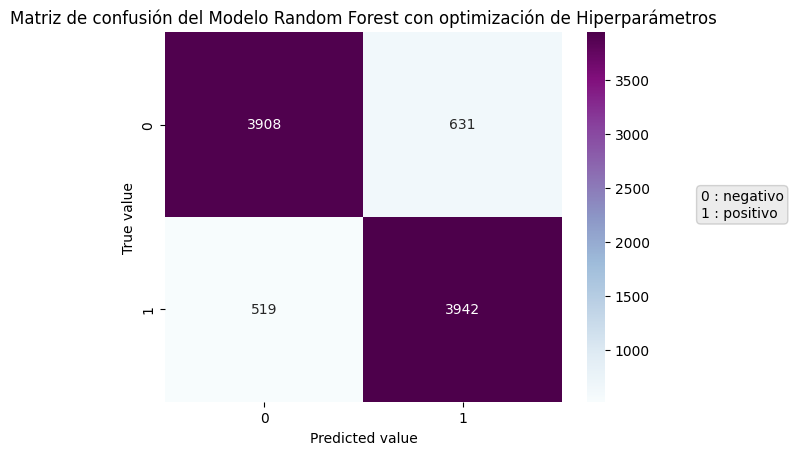

In [36]:
print('F1-Score: {}'.format(f1_score(y_test, y_pred, average='binary')))

confussionMatrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
sns.heatmap(confussionMatrix,cmap='BuPu', annot=True, fmt='g')
plt.xlabel('Predicted value')
plt.ylabel('True value')
plt.title("Matriz de confusión del Modelo Random Forest con optimización de Hiperparámetros")
plt.text(2.7, 1, f"0 : {labelEncoder.inverse_transform([0])[0]}\n1 : {labelEncoder.inverse_transform([1])[0]}", bbox=dict(boxstyle='round', facecolor='grey', alpha=0.15))
plt.show()

Mostramos las distintas métricas

In [37]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f"Accuracy: {str(accuracy)}")
print(f"Recall: {str(recall)}")
print(f"Precision: {str(precision)}")
print(f"f1 score: {str(f1)}")

Accuracy: 0.8722222222222222
Recall: 0.8836583725622058
Precision: 0.862016181937459
f1 score: 0.8727031215408457


Realizamos las predicciones de los datos que vamos a submitear a kaggle

In [38]:
y_pred = rfPipeline.predict(criticsTest["review"])

Agrupamos en el dataframe los valores predichos decodeados con el label encoder

In [39]:
kaggleResult = criticsTest.copy()
kaggleResult.drop(columns=["review"], inplace=True)

kaggleResult["sentimiento"] = labelEncoder.inverse_transform(y_pred)

kaggleResult.head(2)

,ID,sentimiento
0,60000,negativo
1,60001,negativo


Para exportar a Kaggle exportamos el csv. El `runNumber` es sólo un número que ponemos para no pisar los submits

In [40]:
kaggleResult.to_csv(f"submit_{runNumber}_grupo16_gpwin_random_forest.csv", index=False)

Guardamos una serialización del modelo

In [41]:
filename = f'./random_forest_model_{runNumber}.joblib'
modelInfo = {'model': rfPipeline}

joblib.dump(modelInfo, filename)

['./random_forest_model_3.joblib']

## XGBoost con optimización de hiperparámetros

Similar al Random Forest con optimización de hiperparámetros detallado arriba, creamos una pipeline con un CountVectorizer y un TfidfTransformer pero con un predictor que será un clasificador de tipo XGBoost

La optimización de hiperparámetros será de manera bayesiana con la librería optuna. Para el CountVectorizer y el TfidfTransformer se optimizarán los mismos parámetros que con el Random Forest y el Naive Bayes, y para este XGBoost se optimizarán los siguientes parámetros:

- max_depth: profundidad máxima para los árboles base
- learning_rate: learning rate del boosting (el eta del xgb)
- n_estimators: cantidad de árboles sucesivos (boosting rounds)
- min_child_weight: mínima suma de pesos necesaria para tener un nodo hijo
- gamma: (también llamado min_split_loss) es la reducción mínima del loss para hacer unaotra partición en un nodo hoja de un árbol
- subsample: ratio de toma de una submuestra de la data de training para evitar overfitting
- colsample_bytree: similar a subsample pero para columnas en lugar de filas
- reg_alpha: regularización l1
- reg_lambda: regularización l2
- eval_metric: será la métrica que el modelo utilice para evaluar su performance durante training, lo usará para determinar cuándo parar
- use_label_encoder: el label encoder interno de xgboost se deprecó, así que lo seteamos en false para prevenir warnings

Creamos la función objetivo que vamos a optimizar

In [22]:
def objective(trial):

    parametersVectorizer = {
        'strip_accents': trial.suggest_categorical('strip_accents', ['ascii', 'unicode', None]),
        'lowercase': trial.suggest_categorical('lowercase', [True, False]),
        'ngram_range': trial.suggest_categorical('ngram_range', [(1,1), (1,2)]),
        'binary': trial.suggest_categorical('binary', [True, False]),
        'analyzer': 'word'
    }

    parametersTransformer = {
        'norm': trial.suggest_categorical('norm', ['l1', None]),
        'use_idf': trial.suggest_categorical('use_idf', [True, False]),
        'sublinear_tf': trial.suggest_categorical('sublinear_tf', [True, False]),
    }

    parametersModel = {
        'max_depth': trial.suggest_int('max_depth', 2, 7),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 500, 1000, step=5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 0.1),
        'subsample': trial.suggest_loguniform('subsample', 0.7, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 0.2),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 0.2),
        'eval_metric': ['auc'],
        'use_label_encoder': False,
        'device': 'cuda:0',
        'n_jobs': -1
    }

    xgboostPipeline = Pipeline(steps=[
        ('vectorizer', CountVectorizer(**parametersVectorizer)),
        ('tfidfTransformer', TfidfTransformer(**parametersTransformer)),
        ('xgboost', XGBClassifier(**parametersModel))
    ])

    xgboostPipeline.fit(x_train, y_train)
    y_pred = xgboostPipeline.predict(x_test)

    score = f1_score(y_test, y_pred, average='binary')

    return score

Creamos un study que va a ser donde corramos el "estudio de maximizar la función objetivo" definida arriba (que optimiza el f1 score)

In [23]:
study = optuna.create_study(direction='maximize')

[I 2023-11-20 22:12:51,487] A new study created in memory with name: no-name-cbaed2bf-fef2-4362-8303-cf0e52178da8


El método de sampleo de hiperparámetros que seguirá la optimización bayesiana será con el tree-structured Parzen estimators -TPE

In [50]:
study.sampler.__class__.__name__

'TPESampler'

Corremos el estudio

In [24]:
study.optimize(objective, n_trials=20, show_progress_bar=True)

Best trial: 0. Best value: 0.46755:   5%|▌         | 1/20 [01:29<28:17, 89.34s/it]

[I 2023-11-20 22:14:29,679] Trial 0 finished with value: 0.46754984611267225 and parameters: {'strip_accents': 'ascii', 'lowercase': True, 'ngram_range': (1, 2), 'binary': False, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'max_depth': 5, 'learning_rate': 0.013024956430617463, 'n_estimators': 850, 'min_child_weight': 4, 'gamma': 1.9200995163608596e-05, 'subsample': 0.871446312899161, 'reg_alpha': 0.00014404766657110017, 'reg_lambda': 8.473811236643994e-05}. Best is trial 0 with value: 0.46754984611267225.


Best trial: 1. Best value: 0.840375:  10%|█         | 2/20 [02:55<26:18, 87.68s/it]

[I 2023-11-20 22:15:56,191] Trial 1 finished with value: 0.8403745644599303 and parameters: {'strip_accents': 'unicode', 'lowercase': True, 'ngram_range': (1, 1), 'binary': True, 'norm': None, 'use_idf': False, 'sublinear_tf': True, 'max_depth': 5, 'learning_rate': 0.03863930627552271, 'n_estimators': 610, 'min_child_weight': 8, 'gamma': 4.800164133724036e-07, 'subsample': 0.9761840218060336, 'reg_alpha': 0.009689930464744666, 'reg_lambda': 3.0874423292637874e-08}. Best is trial 1 with value: 0.8403745644599303.


Best trial: 2. Best value: 0.862138:  15%|█▌        | 3/20 [03:26<17:25, 61.49s/it]

[I 2023-11-20 22:16:26,526] Trial 2 finished with value: 0.8621376410710333 and parameters: {'strip_accents': 'unicode', 'lowercase': False, 'ngram_range': (1, 1), 'binary': False, 'norm': 'l1', 'use_idf': False, 'sublinear_tf': False, 'max_depth': 2, 'learning_rate': 0.2671908645783684, 'n_estimators': 615, 'min_child_weight': 6, 'gamma': 0.03962339172278712, 'subsample': 0.8062414924084406, 'reg_alpha': 5.750396557532975e-06, 'reg_lambda': 0.0004177428007374301}. Best is trial 2 with value: 0.8621376410710333.


Best trial: 2. Best value: 0.862138:  20%|██        | 4/20 [03:44<11:48, 44.26s/it]

[I 2023-11-20 22:16:44,370] Trial 3 finished with value: 0.09358895073180787 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (1, 1), 'binary': False, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'max_depth': 2, 'learning_rate': 0.025257335397637897, 'n_estimators': 930, 'min_child_weight': 1, 'gamma': 2.459451199280473e-07, 'subsample': 0.9910810045276564, 'reg_alpha': 0.0003212486114474868, 'reg_lambda': 9.88426197672369e-05}. Best is trial 2 with value: 0.8621376410710333.


Best trial: 2. Best value: 0.862138:  25%|██▌       | 5/20 [04:05<08:58, 35.87s/it]

[I 2023-11-20 22:17:05,373] Trial 4 finished with value: 0.18151071025930102 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 1), 'binary': False, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'max_depth': 6, 'learning_rate': 0.01863368985539684, 'n_estimators': 900, 'min_child_weight': 1, 'gamma': 8.763146114337074e-05, 'subsample': 0.9587506263178793, 'reg_alpha': 1.073384693001257e-08, 'reg_lambda': 0.00017722052650990053}. Best is trial 2 with value: 0.8621376410710333.


Best trial: 2. Best value: 0.862138:  30%|███       | 6/20 [04:24<07:04, 30.31s/it]

[I 2023-11-20 22:17:24,879] Trial 5 finished with value: 0.2843869255019081 and parameters: {'strip_accents': None, 'lowercase': False, 'ngram_range': (1, 1), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'max_depth': 5, 'learning_rate': 0.182702445622772, 'n_estimators': 910, 'min_child_weight': 2, 'gamma': 5.958955214415893e-05, 'subsample': 0.8440959699324523, 'reg_alpha': 0.0001362897039476831, 'reg_lambda': 2.9501858703925802e-06}. Best is trial 2 with value: 0.8621376410710333.


Best trial: 2. Best value: 0.862138:  35%|███▌      | 7/20 [07:15<16:30, 76.16s/it]

[I 2023-11-20 22:20:15,447] Trial 6 finished with value: 0.8374266463812216 and parameters: {'strip_accents': 'ascii', 'lowercase': False, 'ngram_range': (1, 1), 'binary': False, 'norm': 'l1', 'use_idf': False, 'sublinear_tf': True, 'max_depth': 5, 'learning_rate': 0.025780023933112812, 'n_estimators': 835, 'min_child_weight': 10, 'gamma': 2.2885208321446504e-07, 'subsample': 0.9225505238556091, 'reg_alpha': 0.0015391800884370945, 'reg_lambda': 4.355099836279059e-05}. Best is trial 2 with value: 0.8621376410710333.


Best trial: 2. Best value: 0.862138:  40%|████      | 8/20 [07:36<11:42, 58.57s/it]

[I 2023-11-20 22:20:36,357] Trial 7 finished with value: 0.0 and parameters: {'strip_accents': None, 'lowercase': False, 'ngram_range': (1, 1), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': False, 'max_depth': 6, 'learning_rate': 0.022606541272246584, 'n_estimators': 995, 'min_child_weight': 4, 'gamma': 0.0002723263965510217, 'subsample': 0.9817511104280182, 'reg_alpha': 1.1766271560364018e-06, 'reg_lambda': 9.897370612597627e-08}. Best is trial 2 with value: 0.8621376410710333.


Best trial: 8. Best value: 0.869767:  45%|████▌     | 9/20 [09:19<13:19, 72.70s/it]

[I 2023-11-20 22:22:20,104] Trial 8 finished with value: 0.8697674418604652 and parameters: {'strip_accents': 'ascii', 'lowercase': True, 'ngram_range': (1, 1), 'binary': False, 'norm': None, 'use_idf': False, 'sublinear_tf': True, 'max_depth': 6, 'learning_rate': 0.14375565102747595, 'n_estimators': 600, 'min_child_weight': 5, 'gamma': 2.943185144949331e-06, 'subsample': 0.8573541329439164, 'reg_alpha': 0.012378424300154067, 'reg_lambda': 0.0802039576188916}. Best is trial 8 with value: 0.8697674418604652.


Best trial: 8. Best value: 0.869767:  50%|█████     | 10/20 [10:38<12:24, 74.47s/it]

[I 2023-11-20 22:23:38,536] Trial 9 finished with value: 0.0 and parameters: {'strip_accents': None, 'lowercase': True, 'ngram_range': (1, 2), 'binary': False, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'max_depth': 3, 'learning_rate': 0.03916127445181478, 'n_estimators': 580, 'min_child_weight': 8, 'gamma': 0.006493928423917253, 'subsample': 0.7674427702675303, 'reg_alpha': 0.004443770909201165, 'reg_lambda': 8.164651877690925e-08}. Best is trial 8 with value: 0.8697674418604652.


Best trial: 10. Best value: 0.877325:  55%|█████▌    | 11/20 [46:51<1:47:31, 716.80s/it]

[I 2023-11-20 22:59:51,778] Trial 10 finished with value: 0.8773250664304695 and parameters: {'strip_accents': 'ascii', 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': False, 'sublinear_tf': False, 'max_depth': 7, 'learning_rate': 0.10925611450394491, 'n_estimators': 500, 'min_child_weight': 6, 'gamma': 2.866492178326239e-08, 'subsample': 0.7035021440100923, 'reg_alpha': 0.07276414683078794, 'reg_lambda': 0.1439342600783656}. Best is trial 10 with value: 0.8773250664304695.


Best trial: 10. Best value: 0.877325:  60%|██████    | 12/20 [1:24:41<2:38:35, 1189.41s/it]

[I 2023-11-20 23:37:42,130] Trial 11 finished with value: 0.8718573485435818 and parameters: {'strip_accents': 'ascii', 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': False, 'sublinear_tf': False, 'max_depth': 7, 'learning_rate': 0.09964516750838151, 'n_estimators': 510, 'min_child_weight': 6, 'gamma': 1.1693944824380681e-08, 'subsample': 0.7296965194303898, 'reg_alpha': 0.14904560359495544, 'reg_lambda': 0.15120475239991713}. Best is trial 10 with value: 0.8773250664304695.


Best trial: 10. Best value: 0.877325:  65%|██████▌   | 13/20 [2:02:30<2:56:55, 1516.49s/it]

[I 2023-11-21 00:15:31,256] Trial 12 finished with value: 0.8732644673997557 and parameters: {'strip_accents': 'ascii', 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': False, 'sublinear_tf': False, 'max_depth': 7, 'learning_rate': 0.08731123464642071, 'n_estimators': 510, 'min_child_weight': 7, 'gamma': 1.1466632250691995e-08, 'subsample': 0.7137587234380963, 'reg_alpha': 0.18400167686427543, 'reg_lambda': 0.10969847657011451}. Best is trial 10 with value: 0.8773250664304695.


Best trial: 10. Best value: 0.877325:  70%|███████   | 14/20 [2:50:17<3:12:26, 1924.40s/it]

[I 2023-11-21 01:03:18,230] Trial 13 finished with value: 0.8759285951879366 and parameters: {'strip_accents': 'ascii', 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': False, 'sublinear_tf': False, 'max_depth': 7, 'learning_rate': 0.0724556023658195, 'n_estimators': 710, 'min_child_weight': 8, 'gamma': 1.1958445171349165e-08, 'subsample': 0.7033352330389713, 'reg_alpha': 0.19073475747559118, 'reg_lambda': 0.013247594217659293}. Best is trial 10 with value: 0.8773250664304695.


Best trial: 10. Best value: 0.877325:  75%|███████▌  | 15/20 [3:35:08<2:59:37, 2155.43s/it]

[I 2023-11-21 01:48:09,056] Trial 14 finished with value: 0.8768067600622638 and parameters: {'strip_accents': 'ascii', 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': False, 'sublinear_tf': False, 'max_depth': 7, 'learning_rate': 0.07485978843651954, 'n_estimators': 735, 'min_child_weight': 10, 'gamma': 2.1058574411791738e-08, 'subsample': 0.7035995587024748, 'reg_alpha': 0.18489362950429572, 'reg_lambda': 0.004964852206582996}. Best is trial 10 with value: 0.8773250664304695.


Best trial: 10. Best value: 0.877325:  80%|████████  | 16/20 [3:47:37<1:55:27, 1731.96s/it]

[I 2023-11-21 02:00:37,622] Trial 15 finished with value: 0.8618225788721556 and parameters: {'strip_accents': 'ascii', 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': False, 'sublinear_tf': False, 'max_depth': 4, 'learning_rate': 0.058532971706873015, 'n_estimators': 725, 'min_child_weight': 10, 'gamma': 1.6905573742109526e-07, 'subsample': 0.7411599462612902, 'reg_alpha': 0.023375839537495068, 'reg_lambda': 0.006283700494930275}. Best is trial 10 with value: 0.8773250664304695.


Best trial: 10. Best value: 0.877325:  85%|████████▌ | 17/20 [4:26:43<1:35:49, 1916.64s/it]

[I 2023-11-21 02:39:43,746] Trial 16 finished with value: 0.8766970843534387 and parameters: {'strip_accents': 'unicode', 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': False, 'sublinear_tf': False, 'max_depth': 7, 'learning_rate': 0.11521117732541597, 'n_estimators': 675, 'min_child_weight': 9, 'gamma': 6.051952654829643e-08, 'subsample': 0.7001891851377209, 'reg_alpha': 0.0008316117406534125, 'reg_lambda': 0.00524049939660136}. Best is trial 10 with value: 0.8773250664304695.


Best trial: 10. Best value: 0.877325:  90%|█████████ | 18/20 [5:04:08<1:07:10, 2015.29s/it]

[I 2023-11-21 03:17:08,695] Trial 17 finished with value: 0.8745019920318725 and parameters: {'strip_accents': 'ascii', 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': False, 'sublinear_tf': False, 'max_depth': 6, 'learning_rate': 0.06411819281561265, 'n_estimators': 780, 'min_child_weight': 3, 'gamma': 1.7490157977717486e-06, 'subsample': 0.762441437687301, 'reg_alpha': 0.034440533000174404, 'reg_lambda': 0.001524555504985967}. Best is trial 10 with value: 0.8773250664304695.


Best trial: 10. Best value: 0.877325:  95%|█████████▌| 19/20 [5:16:46<27:17, 1637.60s/it]  

[I 2023-11-21 03:29:46,451] Trial 18 finished with value: 0.875912408759124 and parameters: {'strip_accents': 'ascii', 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': False, 'sublinear_tf': False, 'max_depth': 4, 'learning_rate': 0.12416515205785979, 'n_estimators': 780, 'min_child_weight': 7, 'gamma': 8.56732518103983e-08, 'subsample': 0.7935470066272902, 'reg_alpha': 0.00204525257666144, 'reg_lambda': 0.018433681418487478}. Best is trial 10 with value: 0.8773250664304695.


Best trial: 10. Best value: 0.877325: 100%|██████████| 20/20 [5:59:00<00:00, 1077.03s/it]

[I 2023-11-21 04:12:00,939] Trial 19 finished with value: 0.8761081560283687 and parameters: {'strip_accents': 'unicode', 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': False, 'sublinear_tf': False, 'max_depth': 7, 'learning_rate': 0.08776985661192416, 'n_estimators': 670, 'min_child_weight': 9, 'gamma': 1.5957217878075644e-06, 'subsample': 0.73257340737243, 'reg_alpha': 0.026233047714112924, 'reg_lambda': 0.19100359314761495}. Best is trial 10 with value: 0.8773250664304695.


Corremos 20 trials más del estudio

In [25]:
study.optimize(objective, n_trials=20, show_progress_bar=True)

Best trial: 10. Best value: 0.877325:   5%|▌         | 1/20 [31:30<9:58:32, 1890.15s/it]

[I 2023-11-21 08:24:53,495] Trial 20 finished with value: 0.8659180977542932 and parameters: {'strip_accents': 'ascii', 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': False, 'sublinear_tf': False, 'max_depth': 6, 'learning_rate': 0.04698464659502092, 'n_estimators': 655, 'min_child_weight': 5, 'gamma': 3.71256665350417e-08, 'subsample': 0.7602368132236837, 'reg_alpha': 0.003386588243930317, 'reg_lambda': 0.031370686490173556}. Best is trial 10 with value: 0.8773250664304695.


Best trial: 10. Best value: 0.877325:  10%|█         | 2/20 [1:05:37<9:54:52, 1982.91s/it]

[I 2023-11-21 08:59:01,332] Trial 21 finished with value: 0.8755145177439092 and parameters: {'strip_accents': 'unicode', 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': False, 'sublinear_tf': False, 'max_depth': 7, 'learning_rate': 0.11955858472349244, 'n_estimators': 545, 'min_child_weight': 9, 'gamma': 4.914361940130884e-08, 'subsample': 0.7048244701238447, 'reg_alpha': 0.0008242245833570964, 'reg_lambda': 0.0043945605254689275}. Best is trial 10 with value: 0.8773250664304695.


Best trial: 22. Best value: 0.878081:  15%|█▌        | 3/20 [1:40:18<9:34:30, 2027.68s/it]

[I 2023-11-21 09:33:42,302] Trial 22 finished with value: 0.8780812791472351 and parameters: {'strip_accents': 'unicode', 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': False, 'sublinear_tf': False, 'max_depth': 7, 'learning_rate': 0.1733041348852672, 'n_estimators': 690, 'min_child_weight': 10, 'gamma': 5.09722660933088e-08, 'subsample': 0.7002662166550172, 'reg_alpha': 0.03214118941200121, 'reg_lambda': 0.0021246903750188053}. Best is trial 22 with value: 0.8780812791472351.


Best trial: 23. Best value: 0.880426:  20%|██        | 4/20 [2:02:15<7:45:54, 1747.13s/it]

[I 2023-11-21 09:55:39,342] Trial 23 finished with value: 0.8804263350727213 and parameters: {'strip_accents': 'unicode', 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': False, 'sublinear_tf': False, 'max_depth': 6, 'learning_rate': 0.19680628234562594, 'n_estimators': 755, 'min_child_weight': 10, 'gamma': 5.638799317931083e-07, 'subsample': 0.7266621391189376, 'reg_alpha': 0.03912815474504474, 'reg_lambda': 0.0014505445591885973}. Best is trial 23 with value: 0.8804263350727213.


Best trial: 24. Best value: 0.880801:  25%|██▌       | 5/20 [2:27:03<6:53:22, 1653.53s/it]

[I 2023-11-21 10:20:26,912] Trial 24 finished with value: 0.8808013355592653 and parameters: {'strip_accents': 'unicode', 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': False, 'sublinear_tf': False, 'max_depth': 6, 'learning_rate': 0.17870036561949088, 'n_estimators': 790, 'min_child_weight': 7, 'gamma': 6.649732929657062e-07, 'subsample': 0.7256430796823332, 'reg_alpha': 0.050899861779897165, 'reg_lambda': 0.0013304616058338234}. Best is trial 24 with value: 0.8808013355592653.


Best trial: 24. Best value: 0.880801:  30%|███       | 6/20 [2:49:35<6:01:55, 1551.09s/it]

[I 2023-11-21 10:42:59,138] Trial 25 finished with value: 0.8778642936596218 and parameters: {'strip_accents': 'unicode', 'lowercase': True, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': False, 'sublinear_tf': False, 'max_depth': 6, 'learning_rate': 0.23470951293237283, 'n_estimators': 790, 'min_child_weight': 9, 'gamma': 6.985176890032422e-07, 'subsample': 0.7300182736464418, 'reg_alpha': 0.031041610846271554, 'reg_lambda': 0.000879194374396648}. Best is trial 24 with value: 0.8808013355592653.


Best trial: 24. Best value: 0.880801:  35%|███▌      | 7/20 [3:16:06<5:38:50, 1563.92s/it]

[I 2023-11-21 11:09:29,473] Trial 26 finished with value: 0.8784880489160645 and parameters: {'strip_accents': 'unicode', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': False, 'sublinear_tf': False, 'max_depth': 6, 'learning_rate': 0.296556982321316, 'n_estimators': 825, 'min_child_weight': 7, 'gamma': 9.28509158747671e-06, 'subsample': 0.7494882879875934, 'reg_alpha': 0.006930049871123641, 'reg_lambda': 0.0014225413190732028}. Best is trial 24 with value: 0.8808013355592653.


Best trial: 24. Best value: 0.880801:  40%|████      | 8/20 [3:29:50<4:25:40, 1328.41s/it]

[I 2023-11-21 11:23:13,617] Trial 27 finished with value: 0.8767793594306049 and parameters: {'strip_accents': 'unicode', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': False, 'sublinear_tf': False, 'max_depth': 4, 'learning_rate': 0.2810903530939488, 'n_estimators': 835, 'min_child_weight': 7, 'gamma': 8.959362684386948e-06, 'subsample': 0.743790229526571, 'reg_alpha': 0.008130230308274937, 'reg_lambda': 0.0005885420489434305}. Best is trial 24 with value: 0.8808013355592653.


Best trial: 24. Best value: 0.880801:  45%|████▌     | 9/20 [3:51:27<4:01:46, 1318.79s/it]

[I 2023-11-21 11:44:51,257] Trial 28 finished with value: 0.875750166703712 and parameters: {'strip_accents': 'unicode', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': False, 'sublinear_tf': False, 'max_depth': 5, 'learning_rate': 0.20483121136471813, 'n_estimators': 855, 'min_child_weight': 7, 'gamma': 5.242984713797709e-06, 'subsample': 0.7810024557974321, 'reg_alpha': 0.006398527565489889, 'reg_lambda': 0.0015570013579987363}. Best is trial 24 with value: 0.8808013355592653.


Best trial: 24. Best value: 0.880801:  50%|█████     | 10/20 [3:53:07<2:37:02, 942.25s/it]

[I 2023-11-21 11:46:30,375] Trial 29 finished with value: 0.3148558758314856 and parameters: {'strip_accents': 'unicode', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': False, 'max_depth': 5, 'learning_rate': 0.2846094872458272, 'n_estimators': 810, 'min_child_weight': 4, 'gamma': 2.507598759808632e-05, 'subsample': 0.808626341715446, 'reg_alpha': 0.00397156729501416, 'reg_lambda': 3.795490605868353e-05}. Best is trial 24 with value: 0.8808013355592653.


Best trial: 24. Best value: 0.880801:  55%|█████▌    | 11/20 [4:23:51<3:02:45, 1218.39s/it]

[I 2023-11-21 12:17:14,896] Trial 30 finished with value: 0.8783798820518528 and parameters: {'strip_accents': 'unicode', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': False, 'sublinear_tf': False, 'max_depth': 6, 'learning_rate': 0.15071980791630096, 'n_estimators': 870, 'min_child_weight': 8, 'gamma': 8.107840716701699e-07, 'subsample': 0.7523930947323921, 'reg_alpha': 0.05819397213855205, 'reg_lambda': 0.00019712562126530407}. Best is trial 24 with value: 0.8808013355592653.


Best trial: 31. Best value: 0.882054:  60%|██████    | 12/20 [4:54:13<3:06:55, 1401.98s/it]

[I 2023-11-21 12:47:36,760] Trial 31 finished with value: 0.8820535516707236 and parameters: {'strip_accents': 'unicode', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': False, 'sublinear_tf': False, 'max_depth': 6, 'learning_rate': 0.15805841098188547, 'n_estimators': 870, 'min_child_weight': 8, 'gamma': 9.314490228855616e-07, 'subsample': 0.7514171516809955, 'reg_alpha': 0.058655370564501784, 'reg_lambda': 0.00037164056792145917}. Best is trial 31 with value: 0.8820535516707236.


Best trial: 31. Best value: 0.882054:  65%|██████▌   | 13/20 [5:19:43<2:48:06, 1440.92s/it]

[I 2023-11-21 13:13:07,302] Trial 32 finished with value: 0.8767703802832609 and parameters: {'strip_accents': 'unicode', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': False, 'sublinear_tf': False, 'max_depth': 6, 'learning_rate': 0.21749413862296246, 'n_estimators': 755, 'min_child_weight': 8, 'gamma': 9.525964180692183e-06, 'subsample': 0.7222270016351088, 'reg_alpha': 0.013195574758234005, 'reg_lambda': 0.00043459714283932506}. Best is trial 31 with value: 0.8820535516707236.


Best trial: 31. Best value: 0.882054:  70%|███████   | 14/20 [5:40:38<2:18:28, 1384.77s/it]

[I 2023-11-21 13:34:02,323] Trial 33 finished with value: 0.87659385741213 and parameters: {'strip_accents': 'unicode', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': False, 'sublinear_tf': False, 'max_depth': 5, 'learning_rate': 0.16887645943239452, 'n_estimators': 815, 'min_child_weight': 7, 'gamma': 5.871056493377983e-07, 'subsample': 0.7438088793404589, 'reg_alpha': 0.07975896234484577, 'reg_lambda': 0.0016739210698873087}. Best is trial 31 with value: 0.8820535516707236.


Best trial: 31. Best value: 0.882054:  75%|███████▌  | 15/20 [6:13:28<2:10:05, 1561.07s/it]

[I 2023-11-21 14:06:51,977] Trial 34 finished with value: 0.8780922665478047 and parameters: {'strip_accents': 'unicode', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': False, 'sublinear_tf': False, 'max_depth': 6, 'learning_rate': 0.22412568086150922, 'n_estimators': 955, 'min_child_weight': 6, 'gamma': 2.578568937382534e-06, 'subsample': 0.7777382962389784, 'reg_alpha': 0.07928317154084275, 'reg_lambda': 0.0003099287763115896}. Best is trial 31 with value: 0.8820535516707236.


Best trial: 31. Best value: 0.882054:  80%|████████  | 16/20 [7:00:31<2:09:24, 1941.02s/it]

[I 2023-11-21 14:53:55,339] Trial 35 finished with value: 0.8666741296317026 and parameters: {'strip_accents': 'unicode', 'lowercase': False, 'ngram_range': (1, 2), 'binary': False, 'norm': 'l1', 'use_idf': False, 'sublinear_tf': False, 'max_depth': 5, 'learning_rate': 0.29167375240759436, 'n_estimators': 895, 'min_child_weight': 8, 'gamma': 3.3865428440035246e-07, 'subsample': 0.7211385642208691, 'reg_alpha': 0.02173174967855837, 'reg_lambda': 9.262959955539293e-05}. Best is trial 31 with value: 0.8820535516707236.


Best trial: 31. Best value: 0.882054:  85%|████████▌ | 17/20 [7:02:08<1:09:19, 1386.49s/it]

[I 2023-11-21 14:55:32,212] Trial 36 finished with value: 0.3773148148148148 and parameters: {'strip_accents': 'unicode', 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': None, 'use_idf': True, 'sublinear_tf': True, 'max_depth': 6, 'learning_rate': 0.14301884412303917, 'n_estimators': 760, 'min_child_weight': 5, 'gamma': 1.1166962314919047e-06, 'subsample': 0.7489651611680767, 'reg_alpha': 0.008716802040193141, 'reg_lambda': 0.0010154814600722326}. Best is trial 31 with value: 0.8820535516707236.


Best trial: 31. Best value: 0.882054:  90%|█████████ | 18/20 [7:04:20<33:38, 1009.30s/it]  

[I 2023-11-21 14:57:43,471] Trial 37 finished with value: 0.8632144055474779 and parameters: {'strip_accents': 'unicode', 'lowercase': False, 'ngram_range': (1, 1), 'binary': False, 'norm': 'l1', 'use_idf': False, 'sublinear_tf': False, 'max_depth': 5, 'learning_rate': 0.24091162726168766, 'n_estimators': 875, 'min_child_weight': 9, 'gamma': 1.1877806422098939e-07, 'subsample': 0.7236083555345778, 'reg_alpha': 0.015260683747286032, 'reg_lambda': 2.316665692888813e-05}. Best is trial 31 with value: 0.8820535516707236.


Best trial: 31. Best value: 0.882054:  95%|█████████▌| 19/20 [7:06:23<12:23, 743.33s/it] 

[I 2023-11-21 14:59:47,191] Trial 38 finished with value: 0.5480311553440069 and parameters: {'strip_accents': None, 'lowercase': False, 'ngram_range': (1, 2), 'binary': True, 'norm': 'l1', 'use_idf': True, 'sublinear_tf': True, 'max_depth': 6, 'learning_rate': 0.18682584202228003, 'n_estimators': 945, 'min_child_weight': 7, 'gamma': 4.4403412132103666e-07, 'subsample': 0.8158110435424084, 'reg_alpha': 0.06302743553475912, 'reg_lambda': 0.00017895525023569266}. Best is trial 31 with value: 0.8820535516707236.


Best trial: 31. Best value: 0.882054: 100%|██████████| 20/20 [7:07:11<00:00, 1281.60s/it]

[I 2023-11-21 15:00:35,294] Trial 39 finished with value: 0.8709000552181115 and parameters: {'strip_accents': 'unicode', 'lowercase': False, 'ngram_range': (1, 1), 'binary': False, 'norm': None, 'use_idf': False, 'sublinear_tf': False, 'max_depth': 3, 'learning_rate': 0.19414764337587131, 'n_estimators': 810, 'min_child_weight': 6, 'gamma': 1.9159809292733274e-07, 'subsample': 0.7702916015205092, 'reg_alpha': 0.00024129917976223222, 'reg_lambda': 0.0004424990402997825}. Best is trial 31 with value: 0.8820535516707236.


Las 40 iteraciones del estudio tardaron 13.1 horas en total

Seleccionamos el mejor trial (intento) con el mejor score y el mejor conjunto de hiperparámetros

In [52]:
bestTrial = study.best_trial
bestScore = bestTrial.value
hyperparameters = bestTrial.params

print('Cantidad de trials total: {}'.format(len(study.trials)))
print('Mejor f1score: ' + str(bestScore) + "\n")

for param, value in hyperparameters.items():
    print(f"{param}: {value}")

Cantidad de trials total: 40
Mejor f1score: 0.8820535516707236

strip_accents: unicode
lowercase: False
ngram_range: (1, 2)
binary: True
norm: None
use_idf: False
sublinear_tf: False
max_depth: 6
learning_rate: 0.15805841098188547
n_estimators: 870
min_child_weight: 8
gamma: 9.314490228855616e-07
subsample: 0.7514171516809955
reg_alpha: 0.058655370564501784
reg_lambda: 0.00037164056792145917


Recreamos una pipeline con estos mejores parámetros

In [51]:
runNumber = 6

parametersVectorizer = {
    'strip_accents': hyperparameters["strip_accents"],
    'lowercase': hyperparameters["lowercase"],
    'ngram_range': hyperparameters["ngram_range"],
    'binary': hyperparameters["binary"],
    'analyzer': 'word'
}

parametersTransformer = {
    'norm': hyperparameters["norm"],
    'use_idf': hyperparameters["use_idf"],
    'sublinear_tf': hyperparameters["sublinear_tf"],
}

parametersModel = {
    'max_depth': hyperparameters["max_depth"],
    'learning_rate': hyperparameters["learning_rate"],
    'n_estimators': hyperparameters["n_estimators"],
    'min_child_weight': hyperparameters["min_child_weight"],
    'gamma': hyperparameters["gamma"],
    'subsample': hyperparameters["subsample"],
    'reg_alpha': hyperparameters["reg_alpha"],
    'reg_lambda': hyperparameters["reg_lambda"],
    'eval_metric': 'mlogloss',
    'use_label_encoder': False,
    'device': 'cuda:0',
    'n_jobs': -1
}

xgboostPipeline = Pipeline(steps=[
    ('vectorizer', CountVectorizer(**parametersVectorizer)),
    ('tfidfTransformer', TfidfTransformer(**parametersTransformer)),
    ('xgboost', XGBClassifier(**parametersModel))
])

xgboostPipeline.fit(x_train, y_train)

Esta es la misma predicción de test que se realizó durante el estudio

In [42]:
y_pred = xgboostPipeline.predict(x_test)

Imprimimos la matriz de confusión. Se agrega una caja de texto con las equivalencias entre las etiquetas numéricas y el sentimiento

F1-Score: 0.8820535516707236


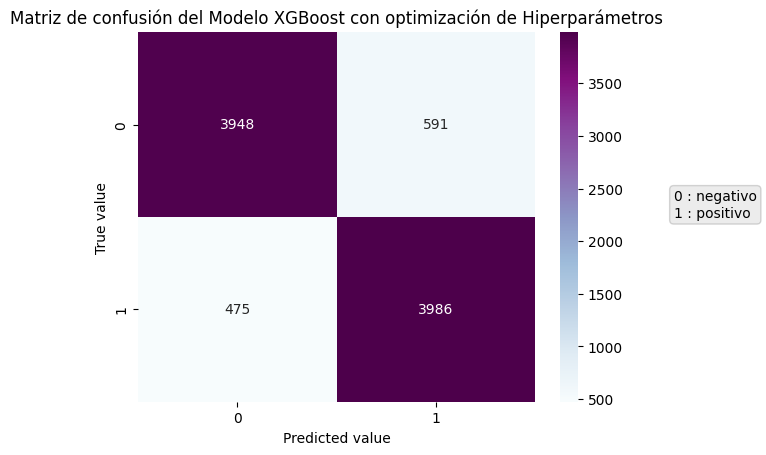

In [44]:
print('F1-Score: {}'.format(f1_score(y_test, y_pred, average='binary')))

confussionMatrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
sns.heatmap(confussionMatrix,cmap='BuPu', annot=True, fmt='g')
plt.xlabel('Predicted value')
plt.ylabel('True value')
plt.title("Matriz de confusión del Modelo XGBoost con optimización de Hiperparámetros")
plt.text(2.7, 1, f"0 : {labelEncoder.inverse_transform([0])[0]}\n1 : {labelEncoder.inverse_transform([1])[0]}", bbox=dict(boxstyle='round', facecolor='grey', alpha=0.15))
plt.show()

Mostramos las distintas métricas

In [45]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f"Accuracy: {str(accuracy)}")
print(f"Recall: {str(recall)}")
print(f"Precision: {str(precision)}")
print(f"f1 score: {str(f1)}")

Accuracy: 0.8815555555555555
Recall: 0.8935216319210939
Precision: 0.8708761197290802
f1 score: 0.8820535516707236


Realizamos las predicciones de los datos que vamos a submitear a kaggle

In [46]:
y_pred = xgboostPipeline.predict(criticsTest["review"])

Agrupamos en el dataframe los valores predichos decodeados con el label encoder

In [47]:
kaggleResult = criticsTest.copy()
kaggleResult.drop(columns=["review"], inplace=True)

kaggleResult["sentimiento"] = labelEncoder.inverse_transform(y_pred)

kaggleResult.head(2)

,ID,sentimiento
0,60000,positivo
1,60001,negativo


Para exportar a Kaggle exportamos el csv. El `runNumber` es sólo un número que ponemos para no pisar los submits

In [48]:
kaggleResult.to_csv(f"submit_{runNumber}_grupo16_gpwin_xgboost.csv", index=False)

Guardamos una serialización del modelo

In [49]:
filename = f'./xgboost_model_{runNumber}.joblib'
modelInfo = {'model': xgboostPipeline}

joblib.dump(modelInfo, filename)

['./xgboost_model_6.joblib']